# Preambles

/Users/longnguyen/Documents/GitHub/qtrl/qtrl/benchmarking/tomography.py:297: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p is not 'I':
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 90
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 90
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 180
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 180


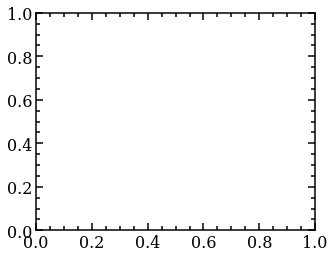

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_evolgates_twod as gates_2d
import plotting_settings
import scipy.linalg
from qutip.qip.operations import cphase as cphase
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
sys.path.append('/Users/longnguyen/Documents/GitHub/qtrl/')
from qtrl.benchmarking import tomography
from qtrl.analysis.state_tomography import generate_tomo_pulse_list, binary_arrays_to_bins, standard_tomography, \
    fidelity, purity, project_and_normalize_density_matrix, mcweeny_purification, dm_from_pulse, pauli_matrix, \
    renormalize_expectation_values, expectation_value_rho
from itertools import product
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'

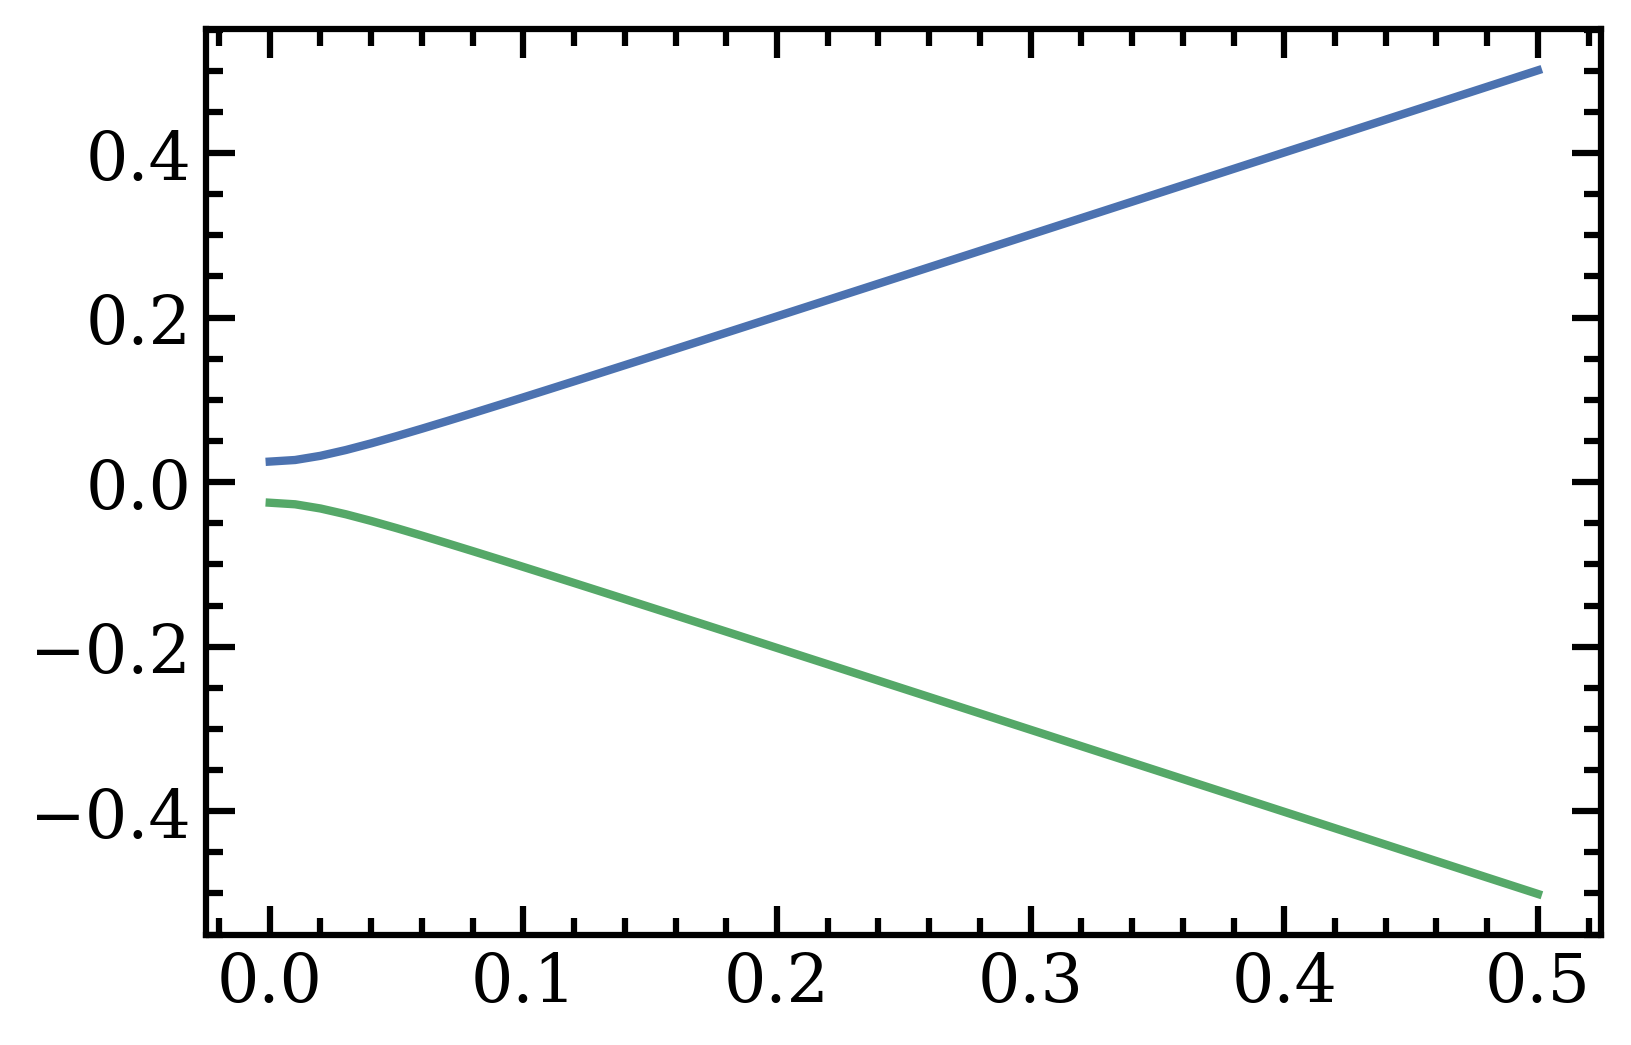

In [2]:
#Define coupled two-level system Hamiltonian
IZ = tensor(qeye(2), sigmaz())
ZI = tensor(sigmaz(), qeye(2))
XI = tensor(sigmax(), qeye(2))
IX = tensor(qeye(2), sigmax())
YI = tensor(sigmay(), qeye(2))
IY = tensor(qeye(2), sigmay())
XX = tensor(sigmax(), sigmax())

def two_q_hamiltonian(w1, w2, J):
    return -0.5*w1*ZI - 0.5*w2*IZ + J*XX

w1 = 0.45
w2 = 0.5
g = np.linspace(0,0.5,51)
energies = np.zeros((len(g), 4))

for idx, J in enumerate(g):
    eig_energies, eig_states = two_q_hamiltonian(w1, w2, J).eigenstates()
    energies[idx,:] = eig_energies
    
plt.plot(g, energies[:,2])  
plt.plot(g, energies[:,1]) 

# Get the correct coupling constant

Text(0, 0.5, '$|\\delta f _{|10\\rangle - |01\\rangle}|~(\\mathrm{MHz})$')

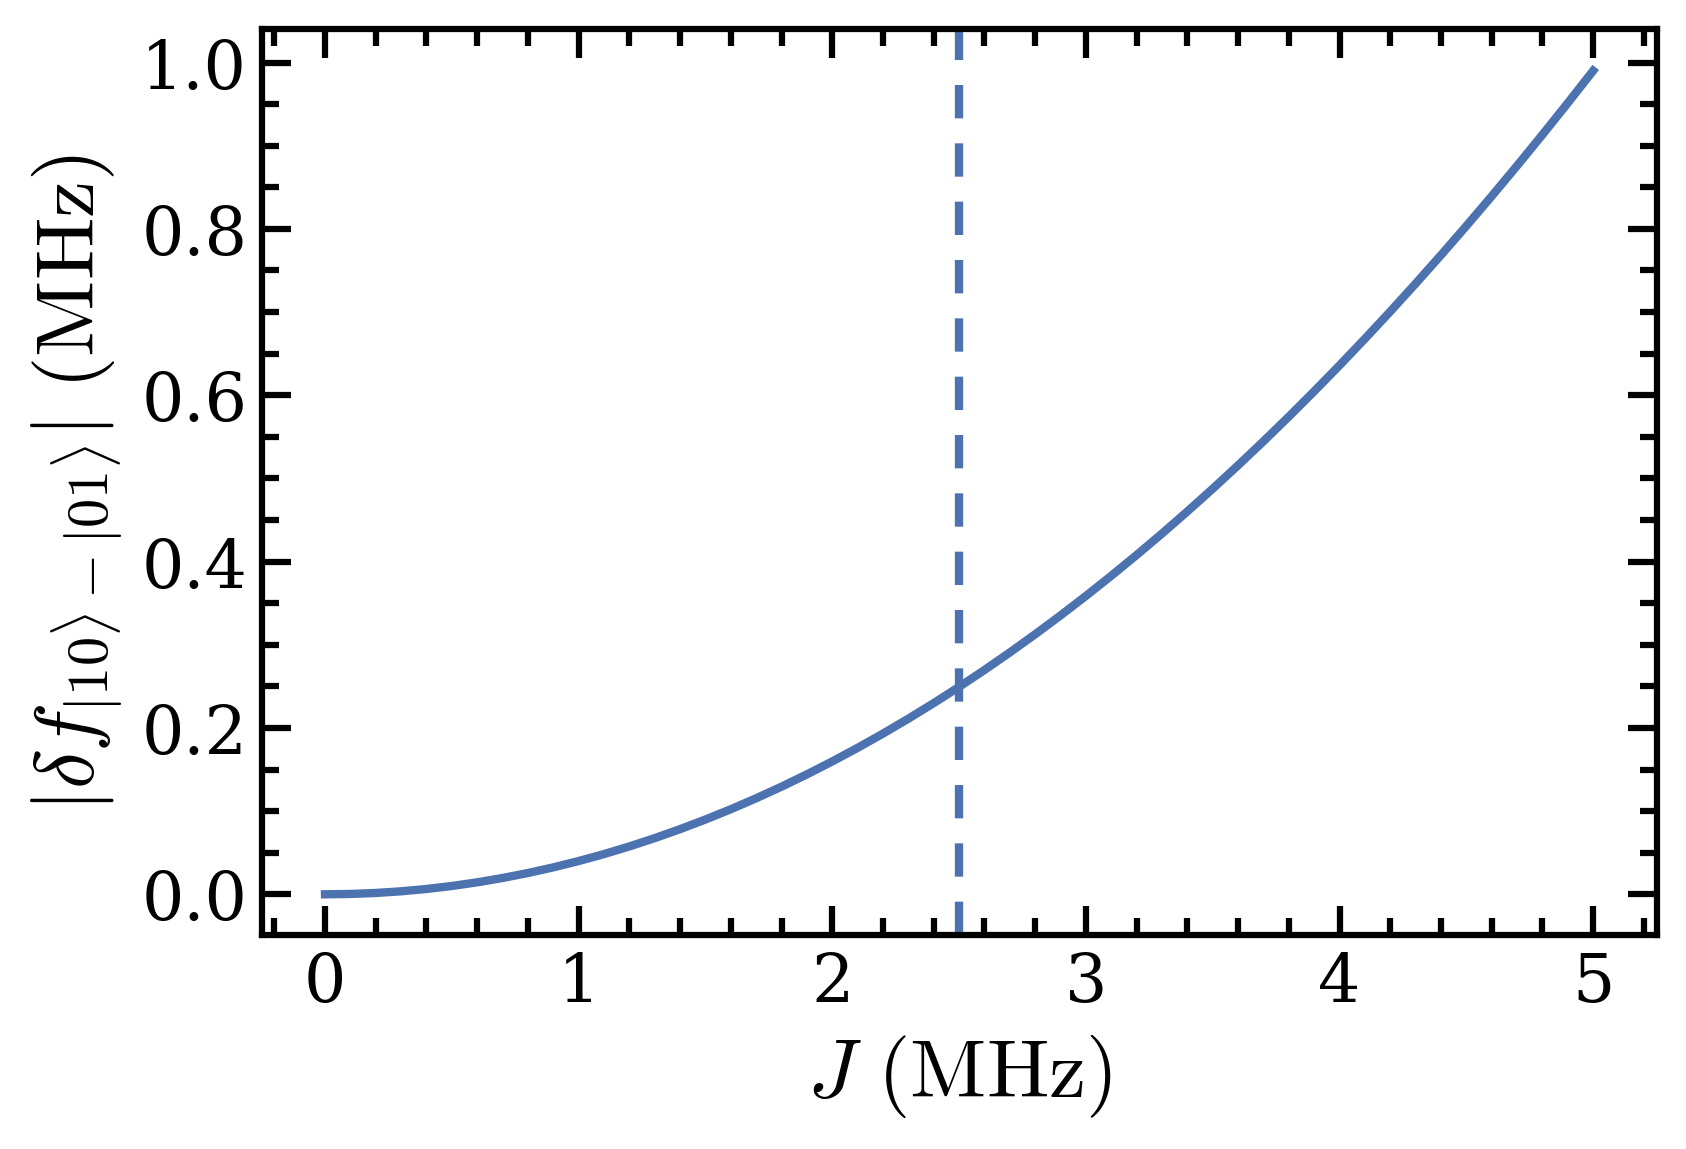

In [4]:
g = np.linspace(0,0.005,51)
energies = np.zeros((len(g), 4))

for idx, J in enumerate(g):
    eig_energies, eig_states = two_q_hamiltonian(w1, w2, J).eigenstates()
    energies[idx,:] = eig_energies
freq_shift = energies[:,2]-energies[:,1]    
freq_anchor = freq_shift[0]  
freq_shift = freq_shift - freq_anchor
plt.plot(g*1e3, freq_shift*1e3)
plt.axvline(x = 2.5, linestyle = '--')
plt.xlabel (r'$J~(\mathrm{MHz})$')
plt.ylabel (r'$|\delta f _{|10\rangle - |01\rangle}|~(\mathrm{MHz})$')

# Static Hamiltonian

In [5]:
#Qubit frequency
w1 = 0.45
w2 = 0.5

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

print ((eig_energies[2] - eig_energies[0]) - (eig_energies[3]-eig_energies[1]))

1.1102230246251565e-16


# Driving Hamiltonian

In [6]:
coupl1 = 41.84249824  #MHz
coupl2= 23.61029908
coupl_const1 = coupl1*1e-3*2*np.pi
coupl_const2 = coupl2*1e-3*2*np.pi
H1 = coupl_const1*XI+coupl_const2*IX

delta_omega_d = 50e-3
drive_freq = eig_energies[2]-eig_energies[0] + delta_omega_d #qubit A

#Gate parameters
T_start = 0
T_gate = 300
shape = 'cos'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2))
U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

# Dynamics analysis

(0.0, 1.0)

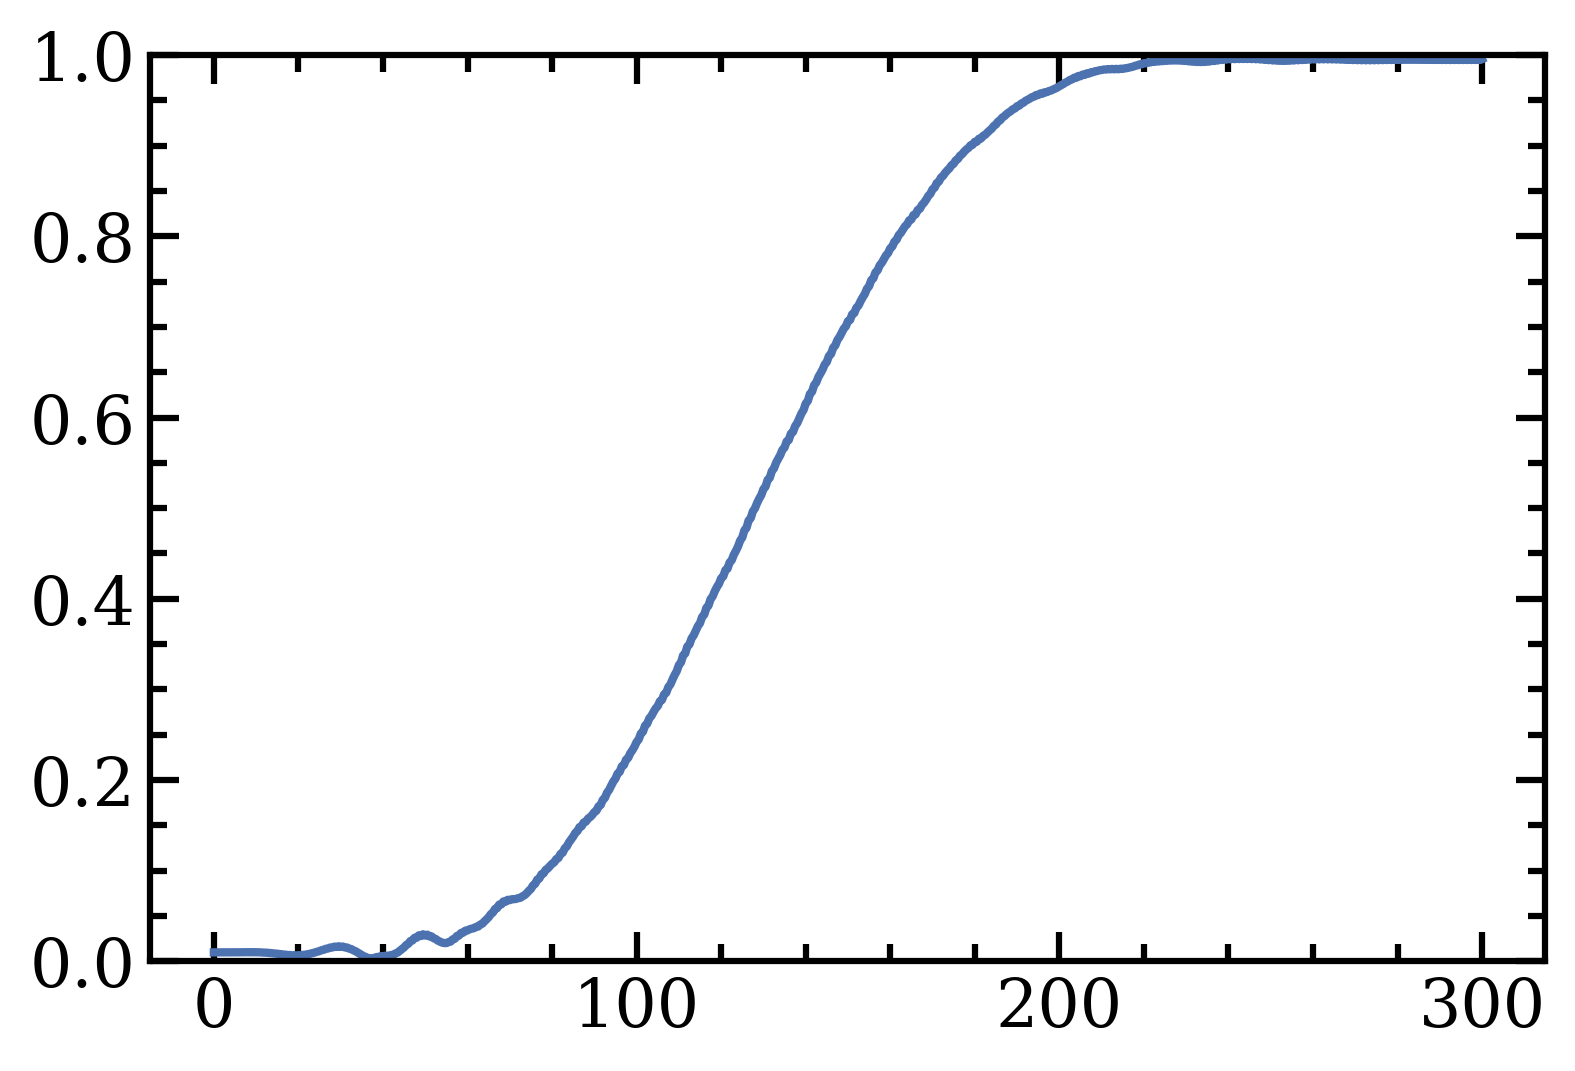

In [7]:
u00 = U_t[-1].matrix_element(state_00, state_00)
u01 = U_t[-1].matrix_element(state_01, state_01)
u10 = U_t[-1].matrix_element(state_10, state_10)
u11 = U_t[-1].matrix_element(state_11, state_11)
phase1 = np.angle(u01/u00)
phase2 = np.angle(u10/u00)
single_qu_z = 0
single_qu_z = single_qu_z + state_00*state_00.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()

trans_prob_00_00 = expect(state_00 * state_00.dag(),U_t*state_00)
trans_prob_00_01 = expect(state_01 * state_01.dag(),U_t*state_00)
trans_prob_00_10 = expect(state_10 * state_10.dag(),U_t*state_00)
trans_prob_00_11 = expect(state_11 * state_11.dag(),U_t*state_00)

# plt.plot(t_points, trans_prob_00_10)
# plt.plot(t_points, trans_prob_00_01)

# Here we find the R vs time
sx0 = expect(IX,U_t*sup_state0)
sy0 = expect(IY,U_t*sup_state0)
sz0 = expect(IZ,U_t*sup_state0)
sx1 = expect(IX,U_t*sup_state1)
sy1 = expect(IY,U_t*sup_state1)
sz1 = expect(IZ,U_t*sup_state1)
R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)

plt.plot(t_points, R, label = 'R')
plt.ylim([0,1])

# Optimization to tune up CZ gate


## With amplitude

In [8]:
#Qubit frequency
w1 = 0.45
w2 = 0.5

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

drive_omega_d = -0.02
drive_freq = eig_energies[1] - eig_energies[0] + drive_omega_d

#Gate parameters
T_start = 0
T_gate = 100
shape = 'cosflattop'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_ideal = cphase(np.pi)

def infidelity(x):
    coupl= x[0]*1e-3*2*np.pi
#     coupl2 = x[1]*1e-3*2*np.pi
    H1 = coupl*XI + coupl*IX
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
    sx0 = expect(IX,U_t*sup_state0)
    sy0 = expect(IY,U_t*sup_state0)
    sz0 = expect(IZ,U_t*sup_state0)
    sx1 = expect(IX,U_t*sup_state1)
    sy1 = expect(IY,U_t*sup_state1)
    sz1 = expect(IZ,U_t*sup_state1)
    R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
    return (1.0 - R[-1])

x0 = [50] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = None)
infidel = infidelity(xopt.x)
print (infidel, xopt.x)
# 0.046769315181411364 [26.44765659]

0.1900734160499542 [65.98524303]


In [9]:
#Qubit frequency
w1 = 0.45
w2 = 0.5

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

drive_omega_d = 0.05
drive_freq_guess = eig_energies[2] - eig_energies[0] + drive_omega_d

#Gate parameters
T_start = 0
T_gate = 300
shape = 'cos'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_ideal = cphase(np.pi)

def infidelity(x):
    coupl1= x[0]*1e-3*2.0*np.pi
    coupl2 = x[1]*1e-3*2.0*np.pi
    drive_freq = x[2]
    H1 = coupl1*XI + coupl2*IX
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0.0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1.0j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1.0j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1.0j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]
    U_real = U

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return (1.0 - fidel)

x0 = [40,20,drive_freq_guess] #guess
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = 1e-8)
infidel = infidelity(xopt.x)
print (infidel, xopt.x)
print (1-infidel)

4.661183881571329e-05 [41.36423838 20.65253912  0.54625669]
0.9999533881611843


In [10]:
#Qubit frequency
w1 = 0.45
w2 = 0.5

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System
comp_space = ['00', '01', '10', '11']
state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

drive_omega_d = 0.05
drive_freq_guess = eig_energies[2] - eig_energies[0] + drive_omega_d

#Gate parameters
T_start = 0
T_gate = 300
shape = 'cos'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_ideal = cphase(np.pi)

def infidelity(x):
    coupl1= x[0]*1e-3*2*np.pi
    coupl2 = x[1]*1e-3*2*np.pi
    drive_freq = x[2]
    H1 = coupl1*XI + coupl2*IX
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
    fidelity = gates.fidelity_cz_gate(
        H0, U_t[-1], comp_space=comp_space,
        interaction='on')
    return (1.0 - fidelity)

x0 = [40,20,drive_freq_guess] #guess
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = 1e-8)
infidel = infidelity(xopt.x)
print (infidel, xopt.x)
print (1-infidel)

AttributeError: 'Qobj' object has no attribute 'projection'

## With separate amplitudes

In [17]:
#Qubit frequency
w1 = 0.25
w2 = 0.3

J = 10e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

drive_omega_d = 0.05
drive_freq = eig_energies[2] - eig_energies[0] + drive_omega_d

#Gate parameters
T_start = 0
T_gate = 200
shape = 'cosflattop'
sigma = 0.25
T_rise = T_gate/3.0
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_ideal = state_00*state_00.dag() + state_10*state_10.dag() + state_01*state_01.dag() - state_11*state_11.dag()

def infidelity(x):
    coupl1 = x[0]*1e-3*2.0*np.pi
    coupl2 = x[1]*1e-3*2.0*np.pi
    H1 = coupl1*XI + coupl2*IX
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
    phase0 = np.angle(U_t[-1].matrix_element(state_00.dag(), state_00))
    phase1 = np.angle(U_t[-1].matrix_element(state_10.dag(), state_10))
    phase2 = np.angle(U_t[-1].matrix_element(state_01.dag(), state_01))
    phase3 = np.angle(U_t[-1].matrix_element(state_11.dag(), state_11))

    single_qu_z = 0
    single_qu_z = single_qu_z + np.exp(-1j*phase0)*state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(1.0j*(phase0 - phase1 - phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]
    U_real = U

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return (1.0 - fidel)

x0 = [50,20]
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = 1e-8)
infidel = infidelity(xopt.x)
print (infidel)
print (xopt.x)

6.504226803816238e-07
[80.94079391 23.76771944]


# Extracting ZZ rate

In [23]:
from scipy.optimize import curve_fit
def line(x,slope,c1,c2):
    return slope*(x-c1)+c2

def zeta_ZZ_analytic(omega, J_qq, detune_1, detune_2):
    return 2*J_qq*omega**2 / (detune_1 * detune_2)

In [222]:
#Qubit frequency
w1 = 0.48
w2 = 0.5

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

delta_omega_d = 10e-3
coupl = 30 #MHz
coupl_const = coupl*1e-3*2*np.pi #GHz rad
drive_freq = eig_energies[1]-eig_energies[0] + delta_omega_d #qubit A
print (drive_freq)
H1 = coupl_const*(XI+IX)

#Gate parameters
T_start = 0
T_gate = 500
shape = 'square'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2))
U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

0.4888451696525658


-29.322054721021388
-72.81152949374494


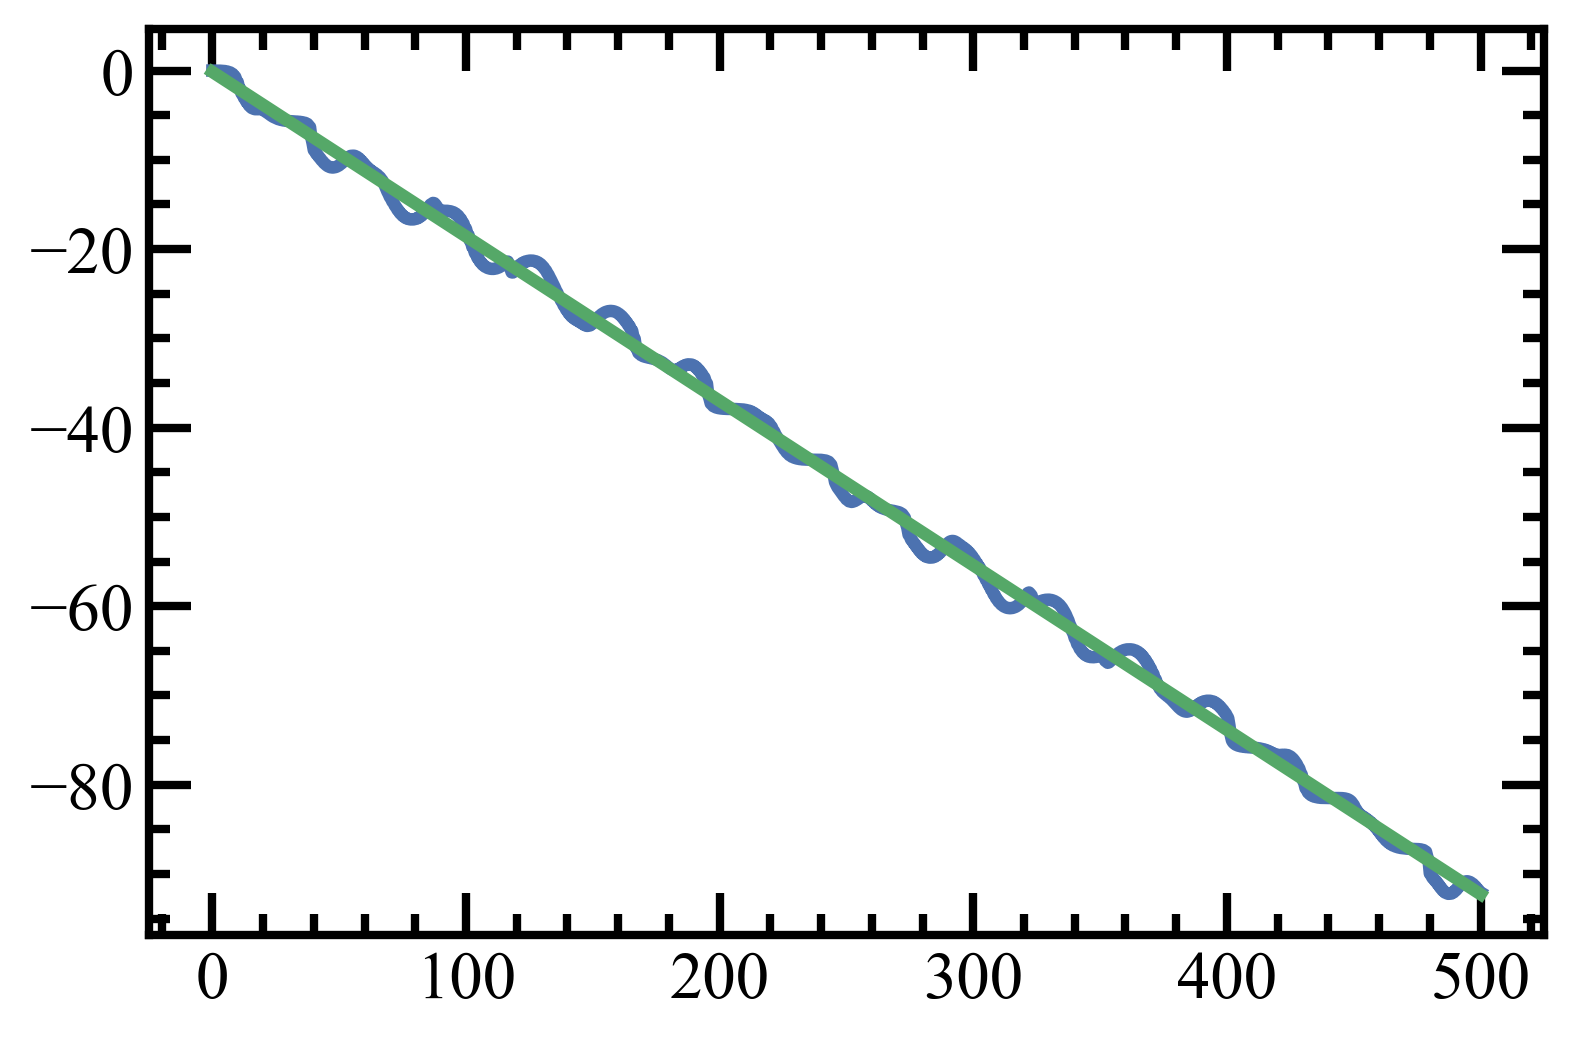

In [223]:
phase_zz = np.zeros_like(t_points)
for idx, t in enumerate(t_points):
    u00 = U_t[idx].matrix_element(state_00, state_00)
    u01 = U_t[idx].matrix_element(state_01, state_01)
    u10 = U_t[idx].matrix_element(state_10, state_10)
    u11 = U_t[idx].matrix_element(state_11, state_11)
    phase_zz[idx] = np.angle(u10*u01/(u11*u00))
plt.plot(t_points, np.unwrap(phase_zz))

slope_guess = (phase_zz[-1]-phase_zz[0])/(t_points[-1]-t_points[0])
guess = [slope_guess,0,0]
opt, cov = curve_fit(line,xdata = t_points, ydata=np.unwrap(phase_zz), p0=guess)
zeta_ZZ = opt[0]/(2*np.pi)*1e3
print (zeta_ZZ)
print (zeta_ZZ_analytic(omega = coupl, J_qq = J*1e3, detune_1 = (drive_freq - (eig_energies[1]-eig_energies[0]))*1e3, detune_2 = (drive_freq - (eig_energies[2]-eig_energies[0]))*1e3))
plt.plot(t_points, line(t_points, *opt))

## Sweeping drive freq, extract ZZ rate

In [32]:
#Qubit frequency
w1 = 0.5
w2 = 0.581

J = 11e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System
w0 = eig_energies[1]-eig_energies[0]
w1 = eig_energies[2]-eig_energies[0]
state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

drive_freq_array = np.linspace(0.4,0.7,151)
zeta_ZZ_array = np.zeros_like(drive_freq_array)
zeta_ZZ_anal_array = np.zeros_like(drive_freq_array)

coupl = 10 #MHz
coupl_const = coupl*1e-3*2*np.pi #GHz rad
H1 = coupl_const*(XI+IX)

#Gate parameters
T_start = 0
T_gate = 500
shape = 'square'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

for freq_idx, drive_freq in enumerate(drive_freq_array):
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)
    phase_zz = np.zeros_like(t_points)
    for idx, t in enumerate(t_points):
        u00 = U_t[idx].matrix_element(state_00, state_00)
        u01 = U_t[idx].matrix_element(state_01, state_01)
        u10 = U_t[idx].matrix_element(state_10, state_10)
        u11 = U_t[idx].matrix_element(state_11, state_11)
        phase_zz[idx] = np.angle(u10*u01/(u11*u00))
    slope_guess = (phase_zz[-1]-phase_zz[0])/(t_points[-1]-t_points[0])
    guess = [slope_guess,0,0]
    opt, cov = curve_fit(line,xdata = t_points, ydata=np.unwrap(phase_zz), p0=guess)
    zeta_ZZ_array[freq_idx] = opt[0]/(2*np.pi)*1e3
    zeta_ZZ_anal_array[freq_idx] = zeta_ZZ_analytic(omega = coupl, J_qq = J*1e3, detune_1 = (drive_freq - w0)*1e3, detune_2 = (drive_freq - w1)*1e3)
np.save(figpath+'/CZ_ZZrate_vs_detuning_TLSnumeric.npy',zeta_ZZ_array)
np.save(figpath+'/CZ_ZZrate_vs_detuning_TLSanal.npy',zeta_ZZ_anal_array)

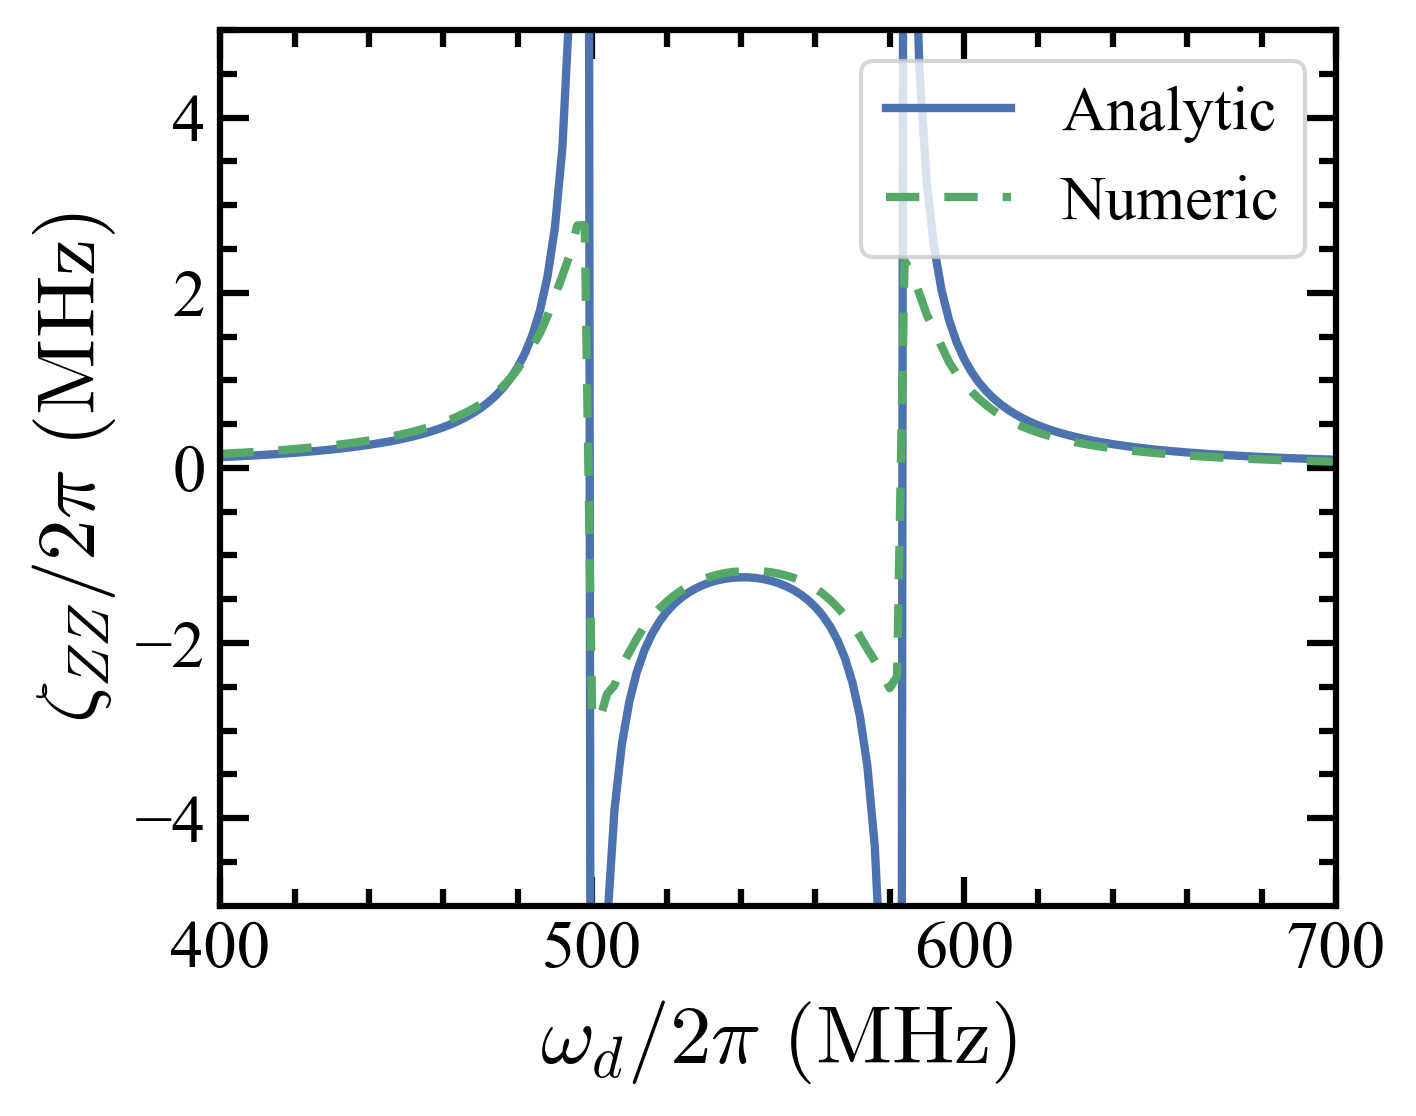

In [37]:
drive_freq_array = np.linspace(0.4,0.7,151)
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_detuning_TLSnumeric.npy')
zeta_ZZ_anal_array = np.load(figpath+'/CZ_ZZrate_vs_detuning_TLSanal.npy')
plt.figure(figsize = [5,4])
plt.plot(drive_freq_array*1e3, zeta_ZZ_anal_array, label = 'Analytic')
plt.plot(drive_freq_array*1e3, zeta_ZZ_array, '--', label = 'Numeric',linewidth = 2.0)
plt.ylim([-5,5])
plt.xlim([400, 700])
plt.xlabel(r'$\omega_d/2\pi~(\mathrm{MHz})$')
plt.ylabel(r'$\zeta_{ZZ}/2\pi~(\mathrm{MHz})$')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.legend()
plt.tight_layout()
figname = 'CZ_gate1.pdf'
plt.savefig(figpath+figname)

## Sweep drive freq and amplitude

In [38]:
#Qubit frequency
w1 = 0.5
w2 = 0.581

J = 11e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System
w0 = eig_energies[1]-eig_energies[0]
w1 = eig_energies[2]-eig_energies[0]
state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

drive_freq_array = np.linspace(0.4,0.7,151)
coupl_array = np.linspace(0,200,51) #MHz
zeta_ZZ_array = np.zeros((len(drive_freq_array),len(coupl_array)))
zeta_ZZ_anal_array = np.zeros_like(zeta_ZZ_array)


#Gate parameters
T_start = 0
T_gate = 500
shape = 'square'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

for coupl_idx, coupl in enumerate(coupl_array):
    coupl_const = coupl*1e-3*2*np.pi #GHz rad
    H1 = coupl_const*(XI+IX)
    for freq_idx, drive_freq in enumerate(drive_freq_array):
        U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
        phase_zz = np.zeros_like(t_points)
        for idx, t in enumerate(t_points):
            u00 = U_t[idx].matrix_element(state_00, state_00)
            u01 = U_t[idx].matrix_element(state_01, state_01)
            u10 = U_t[idx].matrix_element(state_10, state_10)
            u11 = U_t[idx].matrix_element(state_11, state_11)
            phase_zz[idx] = np.angle(u10*u01/(u11*u00))
        slope_guess = (phase_zz[-1]-phase_zz[0])/(t_points[-1]-t_points[0])
        guess = [slope_guess,0,0]
        opt, cov = curve_fit(line,xdata = t_points, ydata=np.unwrap(phase_zz), p0=guess)
        zeta_ZZ_array[freq_idx, coupl_idx] = opt[0]/(2*np.pi)*1e3
        zeta_ZZ_anal_array[freq_idx, coupl_idx] = zeta_ZZ_analytic(omega = coupl, J_qq = J*1e3, detune_1 = (drive_freq - w0)*1e3, detune_2 = (drive_freq - w1)*1e3)
np.save(figpath+'/CZ_ZZrate_vs_freq&coupl_TLSnumeric.npy',zeta_ZZ_array)
np.save(figpath+'/CZ_ZZrate_vs_freq&coupl_TLSanal.npy',zeta_ZZ_anal_array)

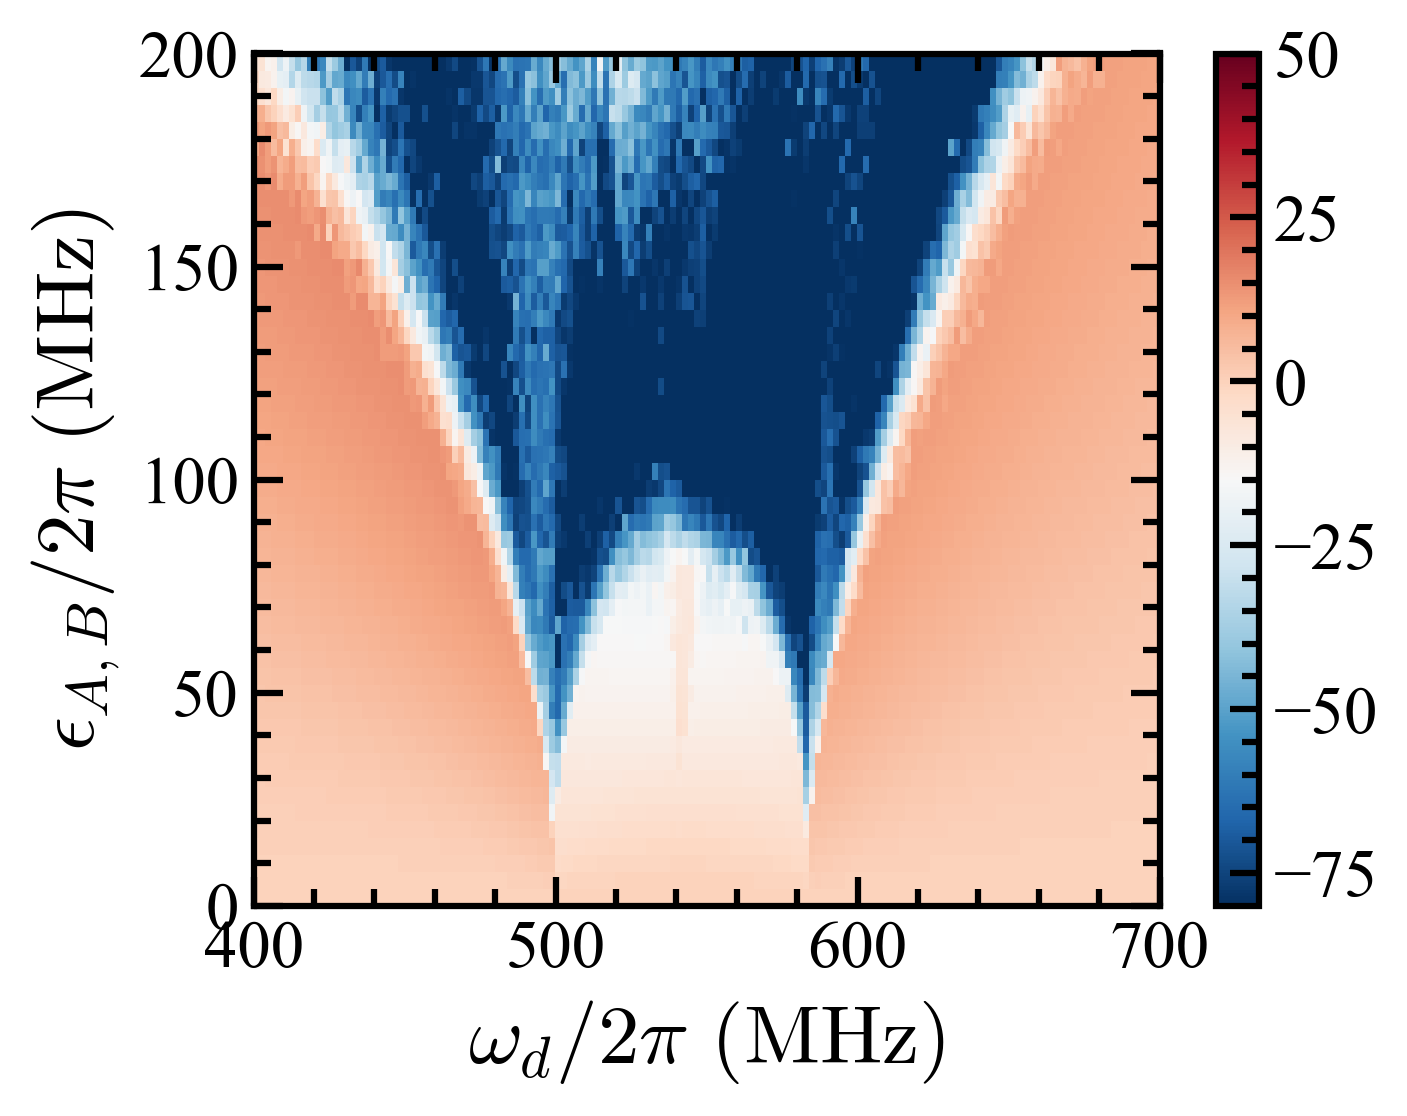

In [109]:
plt.figure(figsize = [5,4])
drive_freq_array = np.linspace(0.4,0.7,151)
coupl_array = np.linspace(0,200,51)
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_freq&coupl_TLSnumeric.npy')
zeta_ZZ_anal_array = np.load(figpath+'/CZ_ZZrate_vs_freq&coupl_TLSanal.npy')
X,Y = np.meshgrid(drive_freq_array*1e3, coupl_array)
Z = zeta_ZZ_array.transpose()
plt.pcolor(X,Y,Z, cmap = 'RdBu_r', vmin = -80, vmax = 50)
plt.colorbar()
plt.ylabel(r'$\epsilon_{A,B}/2\pi~(\mathrm{MHz})$')
plt.xlabel(r'$\omega_d/2\pi~(\mathrm{MHz})$')
# plt.title(r'$\zeta_{ZZ}/2\pi~(\mathrm{MHz})$')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.tight_layout()
figname = 'CZ_gate2_cbar.pdf'
plt.savefig(figpath+figname)

TypeError: Dimensions of C (51, 151) are incompatible with X (126) and/or Y (51); see help(pcolor)

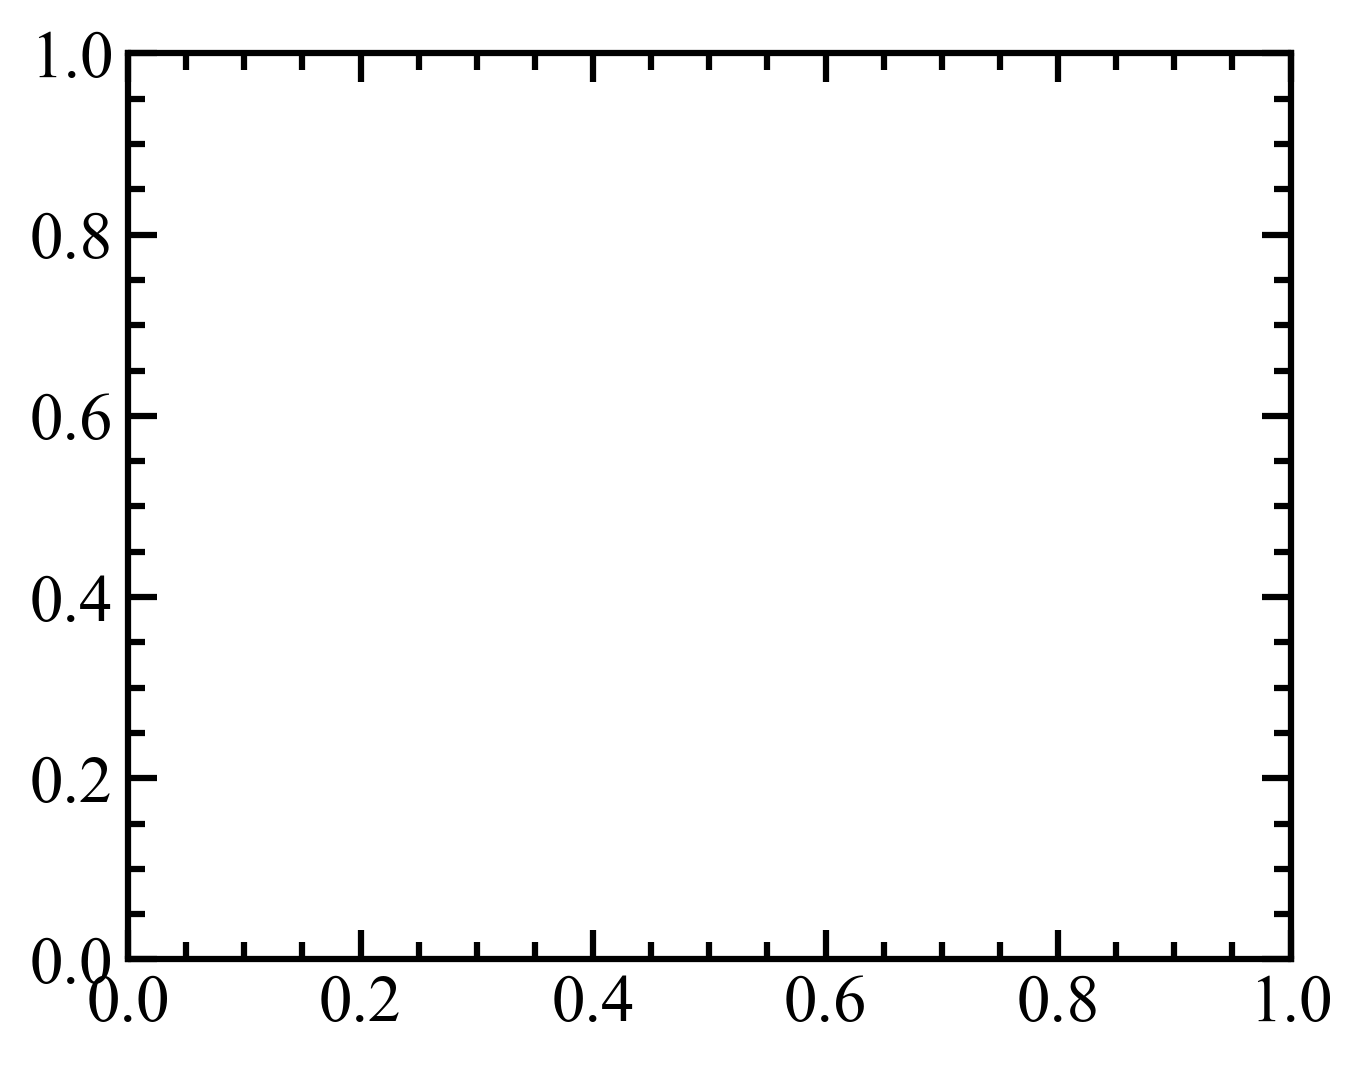

In [107]:
drive_freq_array = np.linspace(0.35,0.6,126)
coupl_array = np.linspace(0,50,51)
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_freq&coupl_TLSnumeric.npy')
zeta_ZZ_anal_array = np.load(figpath+'/CZ_ZZrate_vs_freq&coupl_TLSanal.npy')
plt.figure(figsize = [5,4])
X,Y = np.meshgrid(drive_freq_array*1e3, coupl_array)
Z = zeta_ZZ_anal_array.transpose()
plt.pcolor(X,Y,Z, cmap = 'RdBu_r', vmin = -20, vmax = 20)
# plt.colorbar()
plt.ylabel(r'$\epsilon/2\pi~(\mathrm{MHz})$')
plt.xlabel(r'$\omega_d/2\pi~(\mathrm{MHz})$')
plt.title(r'$\zeta_{ZZ}/2\pi~(\mathrm{MHz})$')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.tight_layout()
# figname = 'CZ_gate2a.pdf'
# plt.savefig(figpath+figname)

## Sweep QQ detuning & drive amplitude

In [88]:
#Qubit frequency
w1 = 0.237
J = 11e-3 #GHz
detuning_array = np.linspace(0.12,1,51)
coupl = 100 #MHz
coupl_const = coupl*1e-3*2*np.pi #GHz rad
H1 = coupl_const*(2*XI+IX)
zeta_ZZ_array = np.zeros((len(detuning_array)))
zeta_ZZ_anal_array = np.zeros_like(zeta_ZZ_array)

#Gate parameters
T_start = 0
T_gate = 500
shape = 'square'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

    
for freq_idx, detuning in enumerate(detuning_array):
    w2 = w1 + detuning
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates() #System
    drive_freq = (eig_energies[2]-eig_energies[0]) +0.05
    state_00 = eig_states[0]
    state_01 = eig_states[2]
    state_10 = eig_states[1]
    state_11 = eig_states[3]
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)
    phase_zz = np.zeros_like(t_points)
    for idx, t in enumerate(t_points):
        u00 = U_t[idx].matrix_element(state_00, state_00)
        u01 = U_t[idx].matrix_element(state_01, state_01)
        u10 = U_t[idx].matrix_element(state_10, state_10)
        u11 = U_t[idx].matrix_element(state_11, state_11)
        phase_zz[idx] = np.angle(u10*u01/(u11*u00))
    slope_guess = (phase_zz[-1]-phase_zz[0])/(t_points[-1]-t_points[0])
    guess = [slope_guess,0,0]
    opt, cov = curve_fit(line,xdata = t_points, ydata=np.unwrap(phase_zz), p0=guess)
    zeta_ZZ_array[freq_idx] = opt[0]/(2*np.pi)*1e3
    zeta_ZZ_anal_array[freq_idx] = zeta_ZZ_analytic(omega = coupl, J_qq = J*1e3, detune_1 = (drive_freq - (eig_energies[1]-eig_energies[0]))*1e3, detune_2 = (drive_freq - (eig_energies[2]-eig_energies[0]))*1e3)
np.save(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric_100.npy',zeta_ZZ_array)
# np.save(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSanal.npy',zeta_ZZ_anal_array)

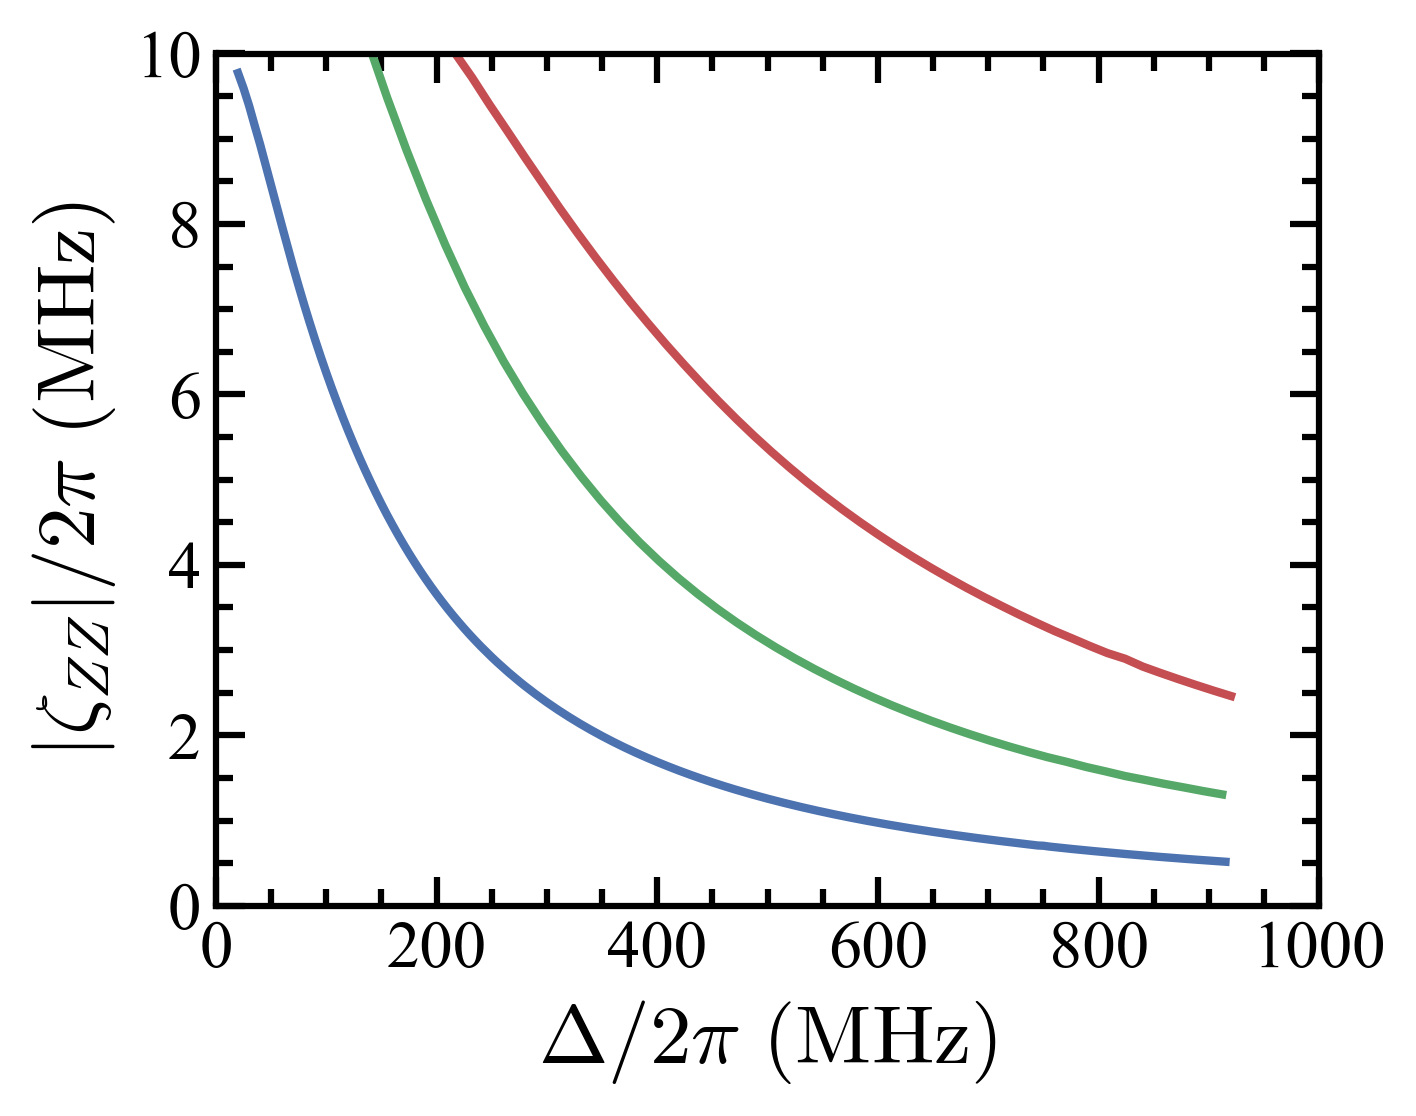

In [103]:
plt.figure(figsize = [5,4])

detuning_array = np.linspace(0.02,1,197)
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric_50.npy')
plt.plot(detuning_array[:180]*1e3, zeta_ZZ_array[:180], label = '50')

detuning_array = np.linspace(0.12,1,51)
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric_100.npy')
plt.plot(detuning_array[:46]*1e3, zeta_ZZ_array[:46], label = '100')

detuning_array = np.linspace(0.2,1,51)
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric_200.npy')
plt.plot(detuning_array[1:46]*1e3, zeta_ZZ_array[1:46], label = '200')

plt.ylim([0,10])
plt.xlim([0, 1000])
plt.xlabel(r'$\Delta/2\pi~(\mathrm{MHz})$')
plt.ylabel(r'$|\zeta_{ZZ}|/2\pi~(\mathrm{MHz})$')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
# plt.legend()
plt.tight_layout()
figname = 'CZ_gate3.pdf'
plt.savefig(figpath+figname)

In [239]:
#Two drives at different frequencies
w1 = 0.4
J = 5e-3 #GHz
detuning_array = np.linspace(0.02,0.2,31)
coupl = 10 #MHz
coupl_const = coupl*1e-3*2*np.pi #GHz rad
H1 = coupl_const*XI
H2 = coupl_const*IX
zeta_ZZ_array = np.zeros((len(detuning_array)))
zeta_ZZ_anal_array = np.zeros_like(zeta_ZZ_array)

#Gate parameters
T_start = 0
T_gate = 200
shape = 'square'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

    
for freq_idx, detuning in enumerate(detuning_array):
    w2 = w1 + detuning
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates() #System
    drive_freq1 = eig_energies[1]-eig_energies[0] - 0.01
    drive_freq2 = eig_energies[2]-eig_energies[0] - 0.01
    state_00 = eig_states[0]
    state_01 = eig_states[2]
    state_10 = eig_states[1]
    state_11 = eig_states[3]
    U_t = gates_2d.evolution_operator_microwave_nonorm(H0,H1, H2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d1=drive_freq1, omega_d2 = drive_freq2)
    phase_zz = np.zeros_like(t_points)
    for idx, t in enumerate(t_points):
        u00 = U_t[idx].matrix_element(state_00, state_00)
        u01 = U_t[idx].matrix_element(state_01, state_01)
        u10 = U_t[idx].matrix_element(state_10, state_10)
        u11 = U_t[idx].matrix_element(state_11, state_11)
        phase_zz[idx] = np.angle(u10*u01/(u11*u00))
    slope_guess = (phase_zz[-1]-phase_zz[0])/(t_points[-1]-t_points[0])
    guess = [slope_guess,0,0]
    opt, cov = curve_fit(line,xdata = t_points, ydata=np.unwrap(phase_zz), p0=guess)
    zeta_ZZ_array[freq_idx] = opt[0]/(2*np.pi)*1e3
    zeta_ZZ_anal_array[freq_idx] = zeta_ZZ_analytic(omega = coupl, J_qq = J*1e3, detune_1 = (drive_freq - (eig_energies[1]-eig_energies[0]))*1e3, detune_2 = (drive_freq - (eig_energies[2]-eig_energies[0]))*1e3)
np.save(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric_2.npy',zeta_ZZ_array)
np.save(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSanal_2.npy',zeta_ZZ_anal_array)

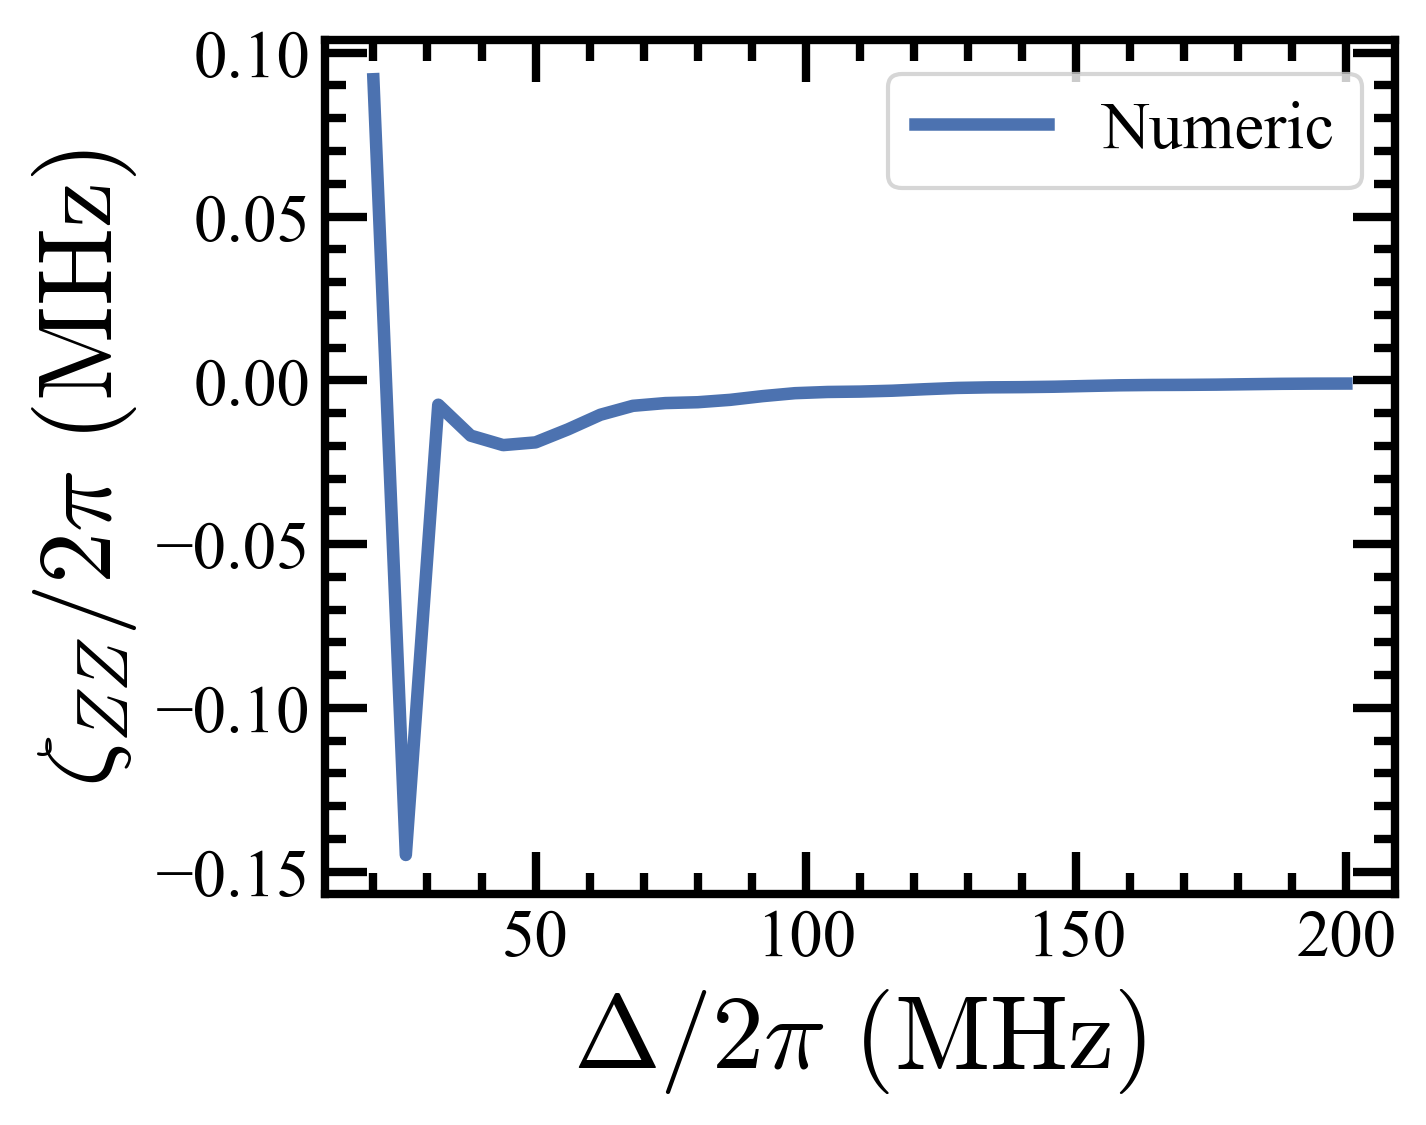

In [241]:
# detuning_array = np.linspace(0.02,0.2,181)
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric_2.npy')
zeta_ZZ_anal_array = np.load(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSanal_2.npy')
plt.figure(figsize = [5,4])
# plt.plot(detuning_array*1e3, zeta_ZZ_anal_array, '--', label = 'Analytic')
plt.plot(detuning_array*1e3, zeta_ZZ_array, label = 'Numeric')
# plt.ylim([-5,0])
# plt.xlim([20, 200])
plt.xlabel(r'$\Delta/2\pi~(\mathrm{MHz})$')
plt.ylabel(r'$\zeta_{ZZ}/2\pi~(\mathrm{MHz})$')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.legend()
plt.tight_layout()

In [226]:
# 2D sweep
w1 = 0.4
J = 5e-3 #GHz
detuning_array = np.linspace(0.05,0.2,51)
coupl_array = np.linspace(0,50,6) #MHz
zeta_ZZ_array = np.zeros((len(detuning_array),len(coupl_array)))
zeta_ZZ_anal_array = np.zeros_like(zeta_ZZ_array)

#Gate parameters
T_start = 0
T_gate = 200
shape = 'square'
sigma = 0.25
T_rise = 50
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

for coupl_idx, coupl in enumerate(coupl_array):
    coupl_const = coupl*1e-3*2*np.pi #GHz rad
    H1 = coupl_const*(XI+IX)
    for freq_idx, detuning in enumerate(detuning_array):
        w2 = w1 + detuning
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates() #System
        drive_freq = eig_energies[1]-eig_energies[0] + detuning/2.0
        state_00 = eig_states[0]
        state_01 = eig_states[2]
        state_10 = eig_states[1]
        state_11 = eig_states[3]
        U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
        phase_zz = np.zeros_like(t_points)
        for idx, t in enumerate(t_points):
            u00 = U_t[idx].matrix_element(state_00, state_00)
            u01 = U_t[idx].matrix_element(state_01, state_01)
            u10 = U_t[idx].matrix_element(state_10, state_10)
            u11 = U_t[idx].matrix_element(state_11, state_11)
            phase_zz[idx] = np.angle(u10*u01/(u11*u00))
        slope_guess = (phase_zz[-1]-phase_zz[0])/(t_points[-1]-t_points[0])
        guess = [slope_guess,0,0]
        opt, cov = curve_fit(line,xdata = t_points, ydata=np.unwrap(phase_zz), p0=guess)
        zeta_ZZ_array[freq_idx, coupl_idx] = opt[0]/(2*np.pi)*1e3
        zeta_ZZ_anal_array[freq_idx, coupl_idx] = zeta_ZZ_analytic(omega = coupl, J_qq = J*1e3, detune_1 = (drive_freq - (eig_energies[1]-eig_energies[0]))*1e3, detune_2 = (drive_freq - (eig_energies[2]-eig_energies[0]))*1e3)
np.save(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric.npy',zeta_ZZ_array)
np.save(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSanal.npy',zeta_ZZ_anal_array)

/Users/longnguyen/opt/anaconda3/envs/qutip-env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/longnguyen/opt/anaconda3/envs/qutip-env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/longnguyen/opt/anaconda3/envs/qutip-env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/longnguyen/opt/anaconda3/envs/qutip-env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/longnguye

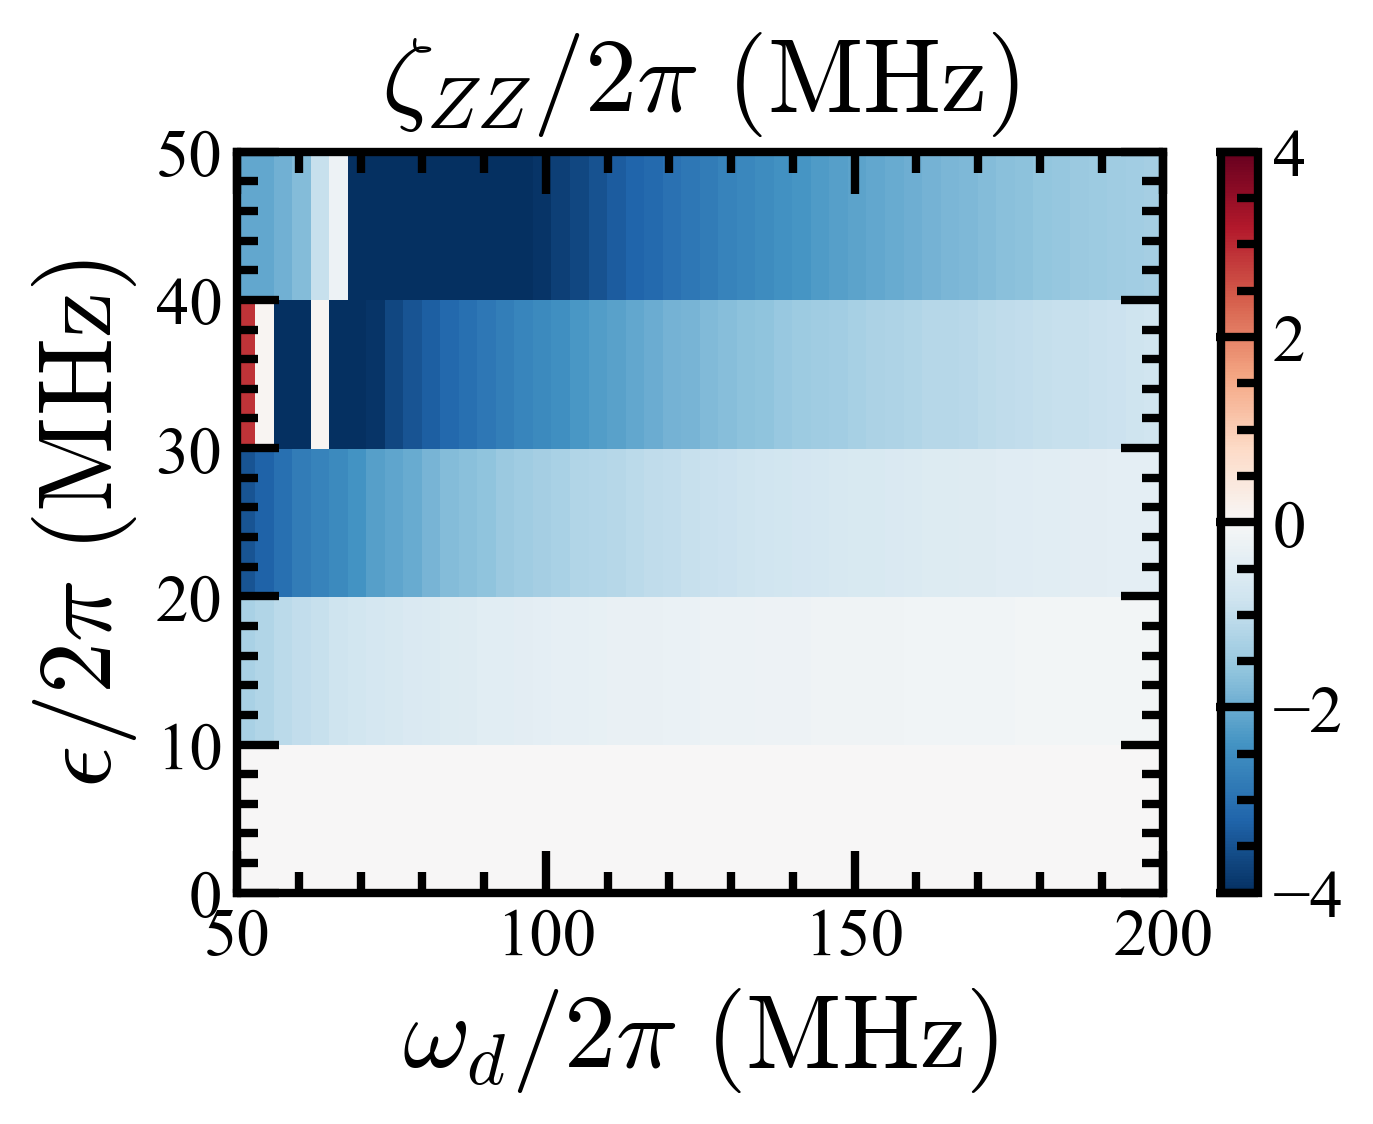

In [228]:
detuning_array = np.linspace(0.05,0.2,51)
coupl_array = np.linspace(0,50,6) 
zeta_ZZ_array = np.load (figpath+'/CZ_ZZrate_vs_qqdetuning_TLSnumeric.npy')
zeta_ZZ_anal_array = np.load(figpath+'/CZ_ZZrate_vs_qqdetuning_TLSanal.npy')
plt.figure(figsize = [5,4])
X,Y = np.meshgrid(detuning_array*1e3, coupl_array)
Z = zeta_ZZ_array.transpose()
plt.pcolor(X,Y,Z, cmap = 'RdBu_r', vmin = -4, vmax = 4)
plt.colorbar()
plt.ylabel(r'$\epsilon/2\pi~(\mathrm{MHz})$')
plt.xlabel(r'$\omega_d/2\pi~(\mathrm{MHz})$')
plt.title(r'$\zeta_{ZZ}/2\pi~(\mathrm{MHz})$')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.tight_layout()
# figname = 'CZ_gate2.pdf'
# plt.savefig(figpath+figname)

# Sweeping gate parameters to find fidelity
## Sweep gate time, T_rise = T_gate/2

In [124]:
#Qubit frequency
w1 = 0.5
w2 = 0.581

J = 11e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

#Gate parameters
T_start = 0
T_gate_array = np.linspace(100,300,101)
delta_omega_d_array = np.array([50,25,-30,-60])*1e-3
guess_amp2 = 20
guess_amp1 = 40
infidelity_array = np.zeros((len(T_gate_array), len(delta_omega_d_array)))

shape = 'cosflattop'
sigma = 0.25
drag = False
drag_coeff = 0.3
U_ideal = state_00*state_00.dag() + state_01*state_01.dag() + state_10*state_10.dag() - state_11*state_11.dag()

for freq_idx, delta_omega_d in enumerate(delta_omega_d_array):
    optimal_amp1 = np.zeros_like(T_gate_array)
    optimal_amp2 = np.zeros_like(T_gate_array)
    drive_freq = eig_energies[2] - eig_energies[0] + delta_omega_d
    for t_idx, T_gate in enumerate(T_gate_array):
#         print (t_idx)
        t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
        T_rise = T_gate/2.0
        def infidelity(x):
            coupl1 = x[0]*1e-3*2*np.pi
            coupl2 = x[1]*1e-3*2*np.pi
            H1 = coupl1*XI+coupl2*IX
            U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)
            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]
            
            U_real = U
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return (1.0 - fidel)
        if t_idx == 0:
            x0 = [guess_amp1, guess_amp2]
        else:
            x0 = [optimal_amp1[t_idx-1], optimal_amp2[t_idx-1]]
        xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = 1e-8)
        optimal_amp1[t_idx] = xopt.x[0]
        optimal_amp2[t_idx] = xopt.x[1]
        infidelity_array[t_idx, freq_idx] = infidelity(xopt.x)
np.save(figpath+'/CZ_fidelity_vs_gatetime_TLS.npy',infidelity_array)        

In [126]:
np.save(figpath+'/CZ_fidelity_vs_gatetime_TLS_50.npy',infidelity_array) 

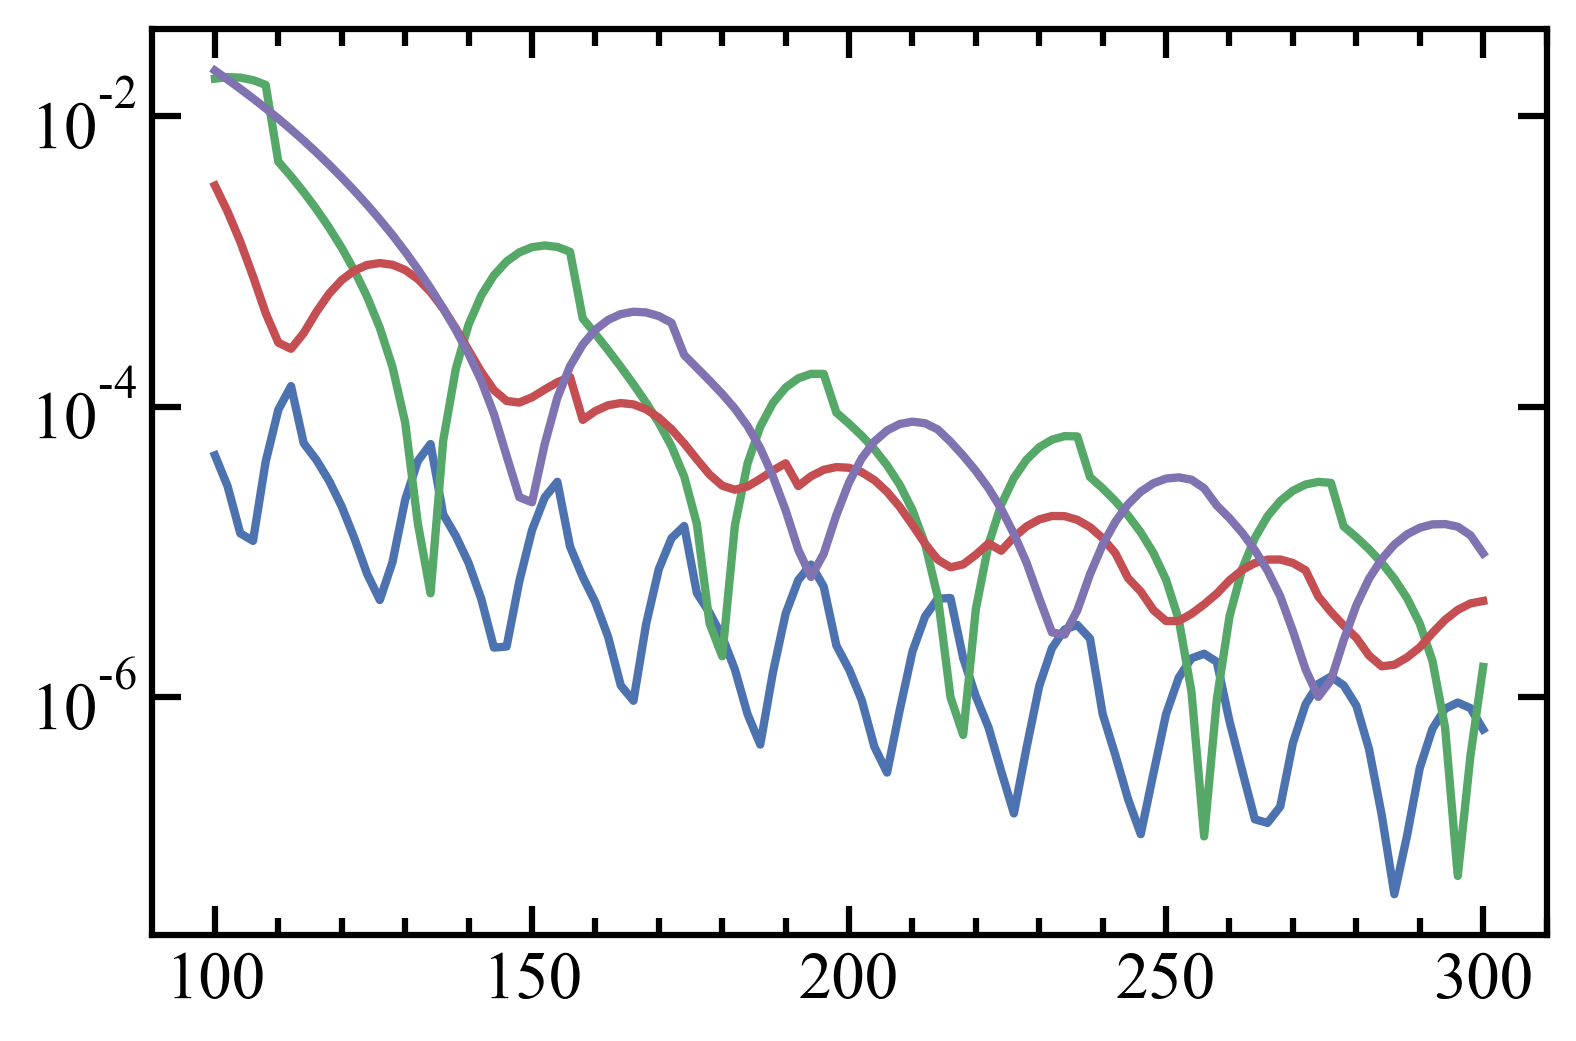

In [125]:
plt.semilogy(T_gate_array, infidelity_array[:, 0], linewidth = 2.0, label = r'$\Delta_A/2\pi = 30~\mathrm{MHz}$')
plt.semilogy(T_gate_array, infidelity_array[:, 1], linewidth = 2.0, label = r'$\Delta_A/2\pi = 30~\mathrm{MHz}$')
plt.semilogy(T_gate_array, infidelity_array[:, 2], linewidth = 2.0, label = r'$\Delta_A/2\pi = 30~\mathrm{MHz}$')
plt.semilogy(T_gate_array, infidelity_array[:, 3], linewidth = 2.0, label = r'$\Delta_A/2\pi = 30~\mathrm{MHz}$')

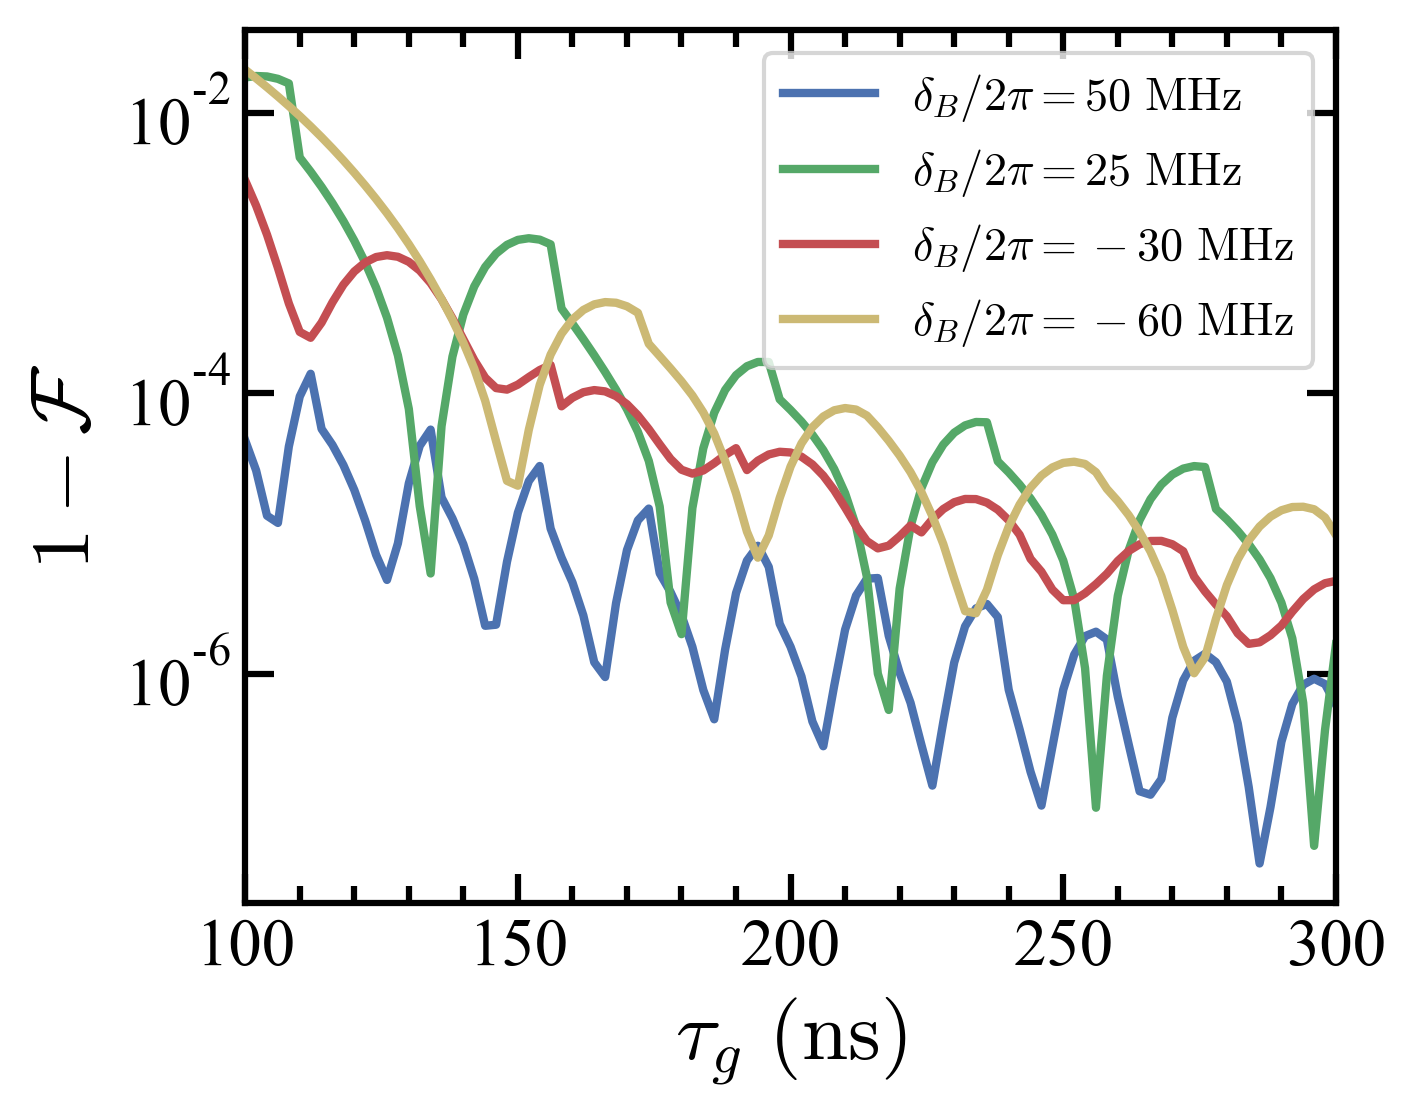

In [5]:
infidelity_array = np.load(figpath+'/CZ_fidelity_vs_gatetime_TLS.npy')
T_gate_array = np.linspace(100,300,101)
from scipy.signal import savgol_filter
plt.figure(figsize = [5,4])
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.semilogy(T_gate_array, infidelity_array[:, 0], linewidth = 2.0, label = r'$\delta_B/2\pi = 50~\mathrm{MHz}$')
plt.semilogy(T_gate_array, infidelity_array[:, 1], linewidth = 2.0, label = r'$\delta_B/2\pi = 25~\mathrm{MHz}$')
plt.semilogy(T_gate_array, infidelity_array[:, 2], linewidth = 2.0, label = r'$\delta_B/2\pi = -30~\mathrm{MHz}$')
plt.semilogy(T_gate_array, infidelity_array[:, 3], linewidth = 2.0, label = r'$\delta_B/2\pi = -60~\mathrm{MHz}$',color = 'C4')
# plt.semilogy(T_gate_array, infidelity_array[:, 4], linewidth = 2.0, label = r'$\Delta_B/2\pi = -40~\mathrm{MHz}$')
# plt.semilogy(T_gate_array, infidelity_array[:, 5], linewidth = 2.0, label = r'$\Delta_B/2\pi = -50~\mathrm{MHz}$')
plt.xlim([100,300])
# plt.ylim([3e-5, 1e-1])
plt.xlabel(r'$\tau_g~(\mathrm{ns})$')
plt.ylabel(r'$1-\mathcal{F}$')
plt.legend(fontsize = 'x-small')
plt.tight_layout()
figname = 'CZ_gate4.pdf'
plt.savefig(figpath+figname)

## Sweep gate time, fixed T_rise

In [ ]:
#Qubit frequency
w1 = 0.45
w2 = 0.5

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

#Gate parameters
T_start = 0
T_gate_array = np.linspace(100,300,101)
drive_freq_array = np.array([0.47, 0.43, 0.42, 0.41, 0.4])
optimal_amp = np.zeros_like(T_gate_array)
guess_amp = np.array([42, 60, 80, 90, 100])
infidelity_array = np.zeros((len(T_gate_array), len(drive_freq_array)))
T_rise = 50

shape = 'cosflattop'
sigma = 0.25
drag = False
drag_coeff = 0.3
U_ideal = cphase(np.pi)

for freq_idx, drive_freq in enumerate(drive_freq_array):
    for t_idx, T_gate in enumerate(T_gate_array):
        t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
        def infidelity(x):
            coupl1 = x[0]*1e-3*2*np.pi
            coupl2 = x[1]*1e-3*2*np.pi
            H1 = coupl1*XI+coupl2*IX
            U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]
            U_real = U
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return 1 - fidel
        if t_idx == 0:
            x0 = [guess_amp[freq_idx], guess_amp[freq_idx]*2]
        else:
            x0 = [optimal_amp[t_idx-1], optimal_amp[t_idx-1]*2]
        xopt = minimize(infidelity, x0, method ='Powell', tol = None)
        optimal_amp[t_idx] = xopt.x[0]
        infidelity_array[t_idx, freq_idx] = infidelity(xopt.x)
# np.save(figpath+'/CZ_fidelity_vs_gatetime_TLS.npy',infidelity_array)   

## Sweep qubit-qubit detuning

In [564]:
detuning_array = np.linspace(50,250,101)*1e-3
delta_omega_d_array = np.array([-50e-3, -40e-3, 20e-3])
guess_amp = np.array([50, 50, 20])

infidelity_array = np.zeros((len(detuning_array), len(delta_omega_d_array)))
amplitude1_array = np.zeros_like(detuning_array)
amplitude2_array = np.zeros_like(detuning_array)

#Qubit frequency
w1 = 0.4
J = 5e-3 #GHz


#Gate parameters
T_start = 0
T_gate = 200
shape = 'cosflattop'
sigma = 0.25
T_rise = 100
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_ideal = cphase(np.pi)

for drive_idx, delta_omega_d in enumerate(delta_omega_d_array):
    for freq_idx, freq_delta in enumerate(detuning_array):
        w2 = w1 + freq_delta
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates()
        state_00 = eig_states[0]
        state_01 = eig_states[2]
        state_10 = eig_states[1]
        state_11 = eig_states[3]
        drive_freq = eig_energies[1]-eig_energies[0] + delta_omega_d #qubit A

        def infidelity(x):
            coupl1 = x[0]*1e-3*2*np.pi
            coupl2 = x[1]*1e-3*2*np.pi
            H1 = coupl1*XI + coupl2*IX
            U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)
            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_real = U
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return (1.0 - fidel)

        if freq_idx == 0:
            if drive_idx == 3:
                coupl_guess1 = guess_amp[drive_idx]
                coupl_guess2 = guess_amp[drive_idx]/2.0
            else:
            coupl_guess1 = guess_amp[drive_idx]
            coupl_guess2 = guess_amp[drive_idx]*2
        else: 
            coupl_guess1 = amplitude1_array[freq_idx-1]
            coupl_guess2 = amplitude2_array[freq_idx-1]
        x0 = [coupl_guess1, coupl_guess2]
        xopt = minimize(infidelity, x0, method ='Powell', tol = None)
        amplitude1_array[freq_idx] = xopt.x[0]
        amplitude2_array[freq_idx] = xopt.x[1]
        infidelity_array[freq_idx, drive_idx] = infidelity(xopt.x)
np.save(figpath+'/CZ_fidelity_vs_detuning_TLS.npy',infidelity_array)

In [623]:
detuning_array = np.linspace(50,250,101)*1e-3
delta_omega_d_array = np.array([30e-3])
guess_amp = np.array([30])

infidelity_array = np.zeros_like(detuning_array)
amplitude1_array = np.zeros_like(detuning_array)
amplitude2_array = np.zeros_like(detuning_array)

#Qubit frequency
w1 = 0.4
J = 5e-3 #GHz


#Gate parameters
T_start = 0
T_gate = 200
shape = 'cosflattop'
sigma = 0.25
T_rise = 100
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_ideal = cphase(np.pi)

for drive_idx, delta_omega_d in enumerate(delta_omega_d_array):
    for freq_idx, freq_delta in enumerate(detuning_array):
        w2 = w1 + freq_delta
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates()
        state_00 = eig_states[0]
        state_01 = eig_states[2]
        state_10 = eig_states[1]
        state_11 = eig_states[3]
        drive_freq = eig_energies[1]-eig_energies[0] + delta_omega_d #qubit A

        def infidelity(x):
            coupl1 = x[0]*1e-3*2*np.pi
            coupl2 = x[1]*1e-3*2*np.pi
            H1 = coupl1*XI + coupl2*IX
            U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)
            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_real = U
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return (1.0 - fidel)

        coupl_guess1 = 50 * 0.05/freq_delta
        coupl_guess2 = 40 * freq_delta / 0.05
        x0 = [coupl_guess1, coupl_guess2]
        xopt = minimize(infidelity, x0, method ='Powell', tol = None)
        infidelity_array[freq_idx] = infidelity(xopt.x)
np.save(figpath+'/CZ_fidelity_vs_detuning1_TLS.npy',infidelity_array)

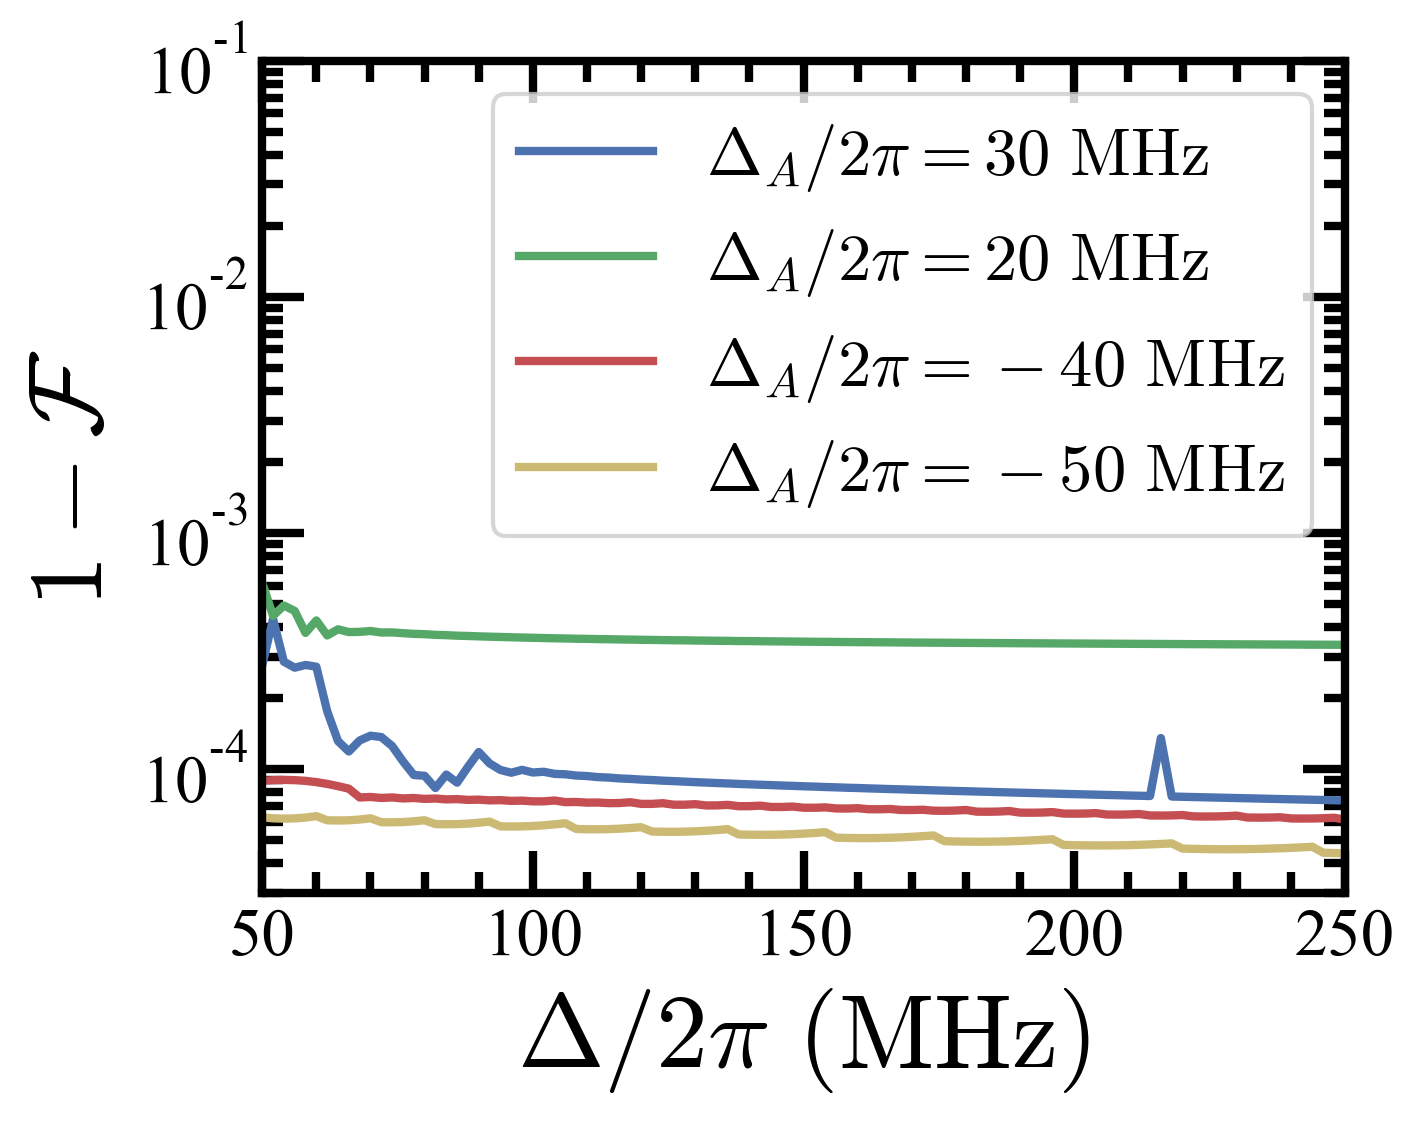

In [624]:
plt.figure(figsize = [5,4])
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
detuning_array = np.linspace(50,250,101)*1e-3

infidelity_array = np.load(figpath+'/CZ_fidelity_vs_detuning1_TLS.npy')
plt.semilogy(detuning_array*1e3,infidelity_array, label=r'$\Delta_A/2\pi = 30~\mathrm{MHz}$', linewidth = 2.0)

infidelity_array = np.load(figpath+'/CZ_fidelity_vs_detuning_TLS.npy')
plt.semilogy(detuning_array*1e3,infidelity_array[:,2], label=r'$\Delta_A/2\pi = 20~\mathrm{MHz}$', linewidth = 2.0)
plt.semilogy(detuning_array*1e3,infidelity_array[:,1], label=r'$\Delta_A/2\pi = -40~\mathrm{MHz}$', linewidth = 2.0)
plt.semilogy(detuning_array*1e3,infidelity_array[:,0], label=r'$\Delta_A/2\pi = -50~\mathrm{MHz}$', color = 'C4', linewidth = 2.0)

plt.xlim([50,250])
plt.ylim([3e-5, 1e-1])
plt.legend()
plt.xlabel(r'$\Delta/2\pi~(\mathrm{MHz})$')
plt.ylabel(r'$1-\mathcal{F}$')
plt.tight_layout()
figname = 'CZ_gate5.pdf'
plt.savefig(figpath+figname)

## Sweep qubit-qubit detuning with varying gate time

In [6]:
detuning_array = np.linspace(50,1000,381)*1e-3
T_gate_array = np.array([100, 200, 300])
guess_amp = np.array([100, 50, 30])

# T_gate_array = np.array([100])
# guess_amp = np.array([100])

infidelity_array = np.zeros((len(detuning_array), len(T_gate_array)))
amplitude1_array = np.zeros_like(detuning_array)
amplitude2_array = np.zeros_like(detuning_array)

#Qubit frequency
w1 = 0.4
J = 5e-3 #GHz
delta_omega_d = 0.05

#Gate parameters
T_start = 0
shape = 'cosflattop'
U_ideal = cphase(np.pi)

for t_idx, T_gate in enumerate(T_gate_array):
    t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
    T_rise = T_gate/2.0
    for freq_idx, freq_delta in enumerate(detuning_array):
        w2 = w1 + freq_delta
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates()
        state_00 = eig_states[0]
        state_01 = eig_states[2]
        state_10 = eig_states[1]
        state_11 = eig_states[3]
        drive_freq = eig_energies[2]-eig_energies[0] + delta_omega_d #qubit A

        def infidelity(x):
            coupl1 = x[0]*1e-3*2*np.pi
            coupl2 = x[1]*1e-3*2*np.pi
            H1 = coupl1*XI + coupl2*IX
            U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)
            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_real = U
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return (1.0 - fidel)

        if freq_idx == 0:
            coupl_guess1 = guess_amp[t_idx]*2.5
            coupl_guess2 = guess_amp[t_idx]
        else: 
            coupl_guess1 = amplitude1_array[freq_idx-1]
            coupl_guess2 = amplitude2_array[freq_idx-1]
        x0 = [coupl_guess1, coupl_guess2]
        xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-8)
        amplitude1_array[freq_idx] = xopt.x[0]
        amplitude2_array[freq_idx] = xopt.x[1]
        infidelity_array[freq_idx, t_idx] = infidelity(xopt.x)
np.save(figpath+'/CZ_fidelity_vs_detuning_1GHz_gateTime_TLS1.npy',infidelity_array)

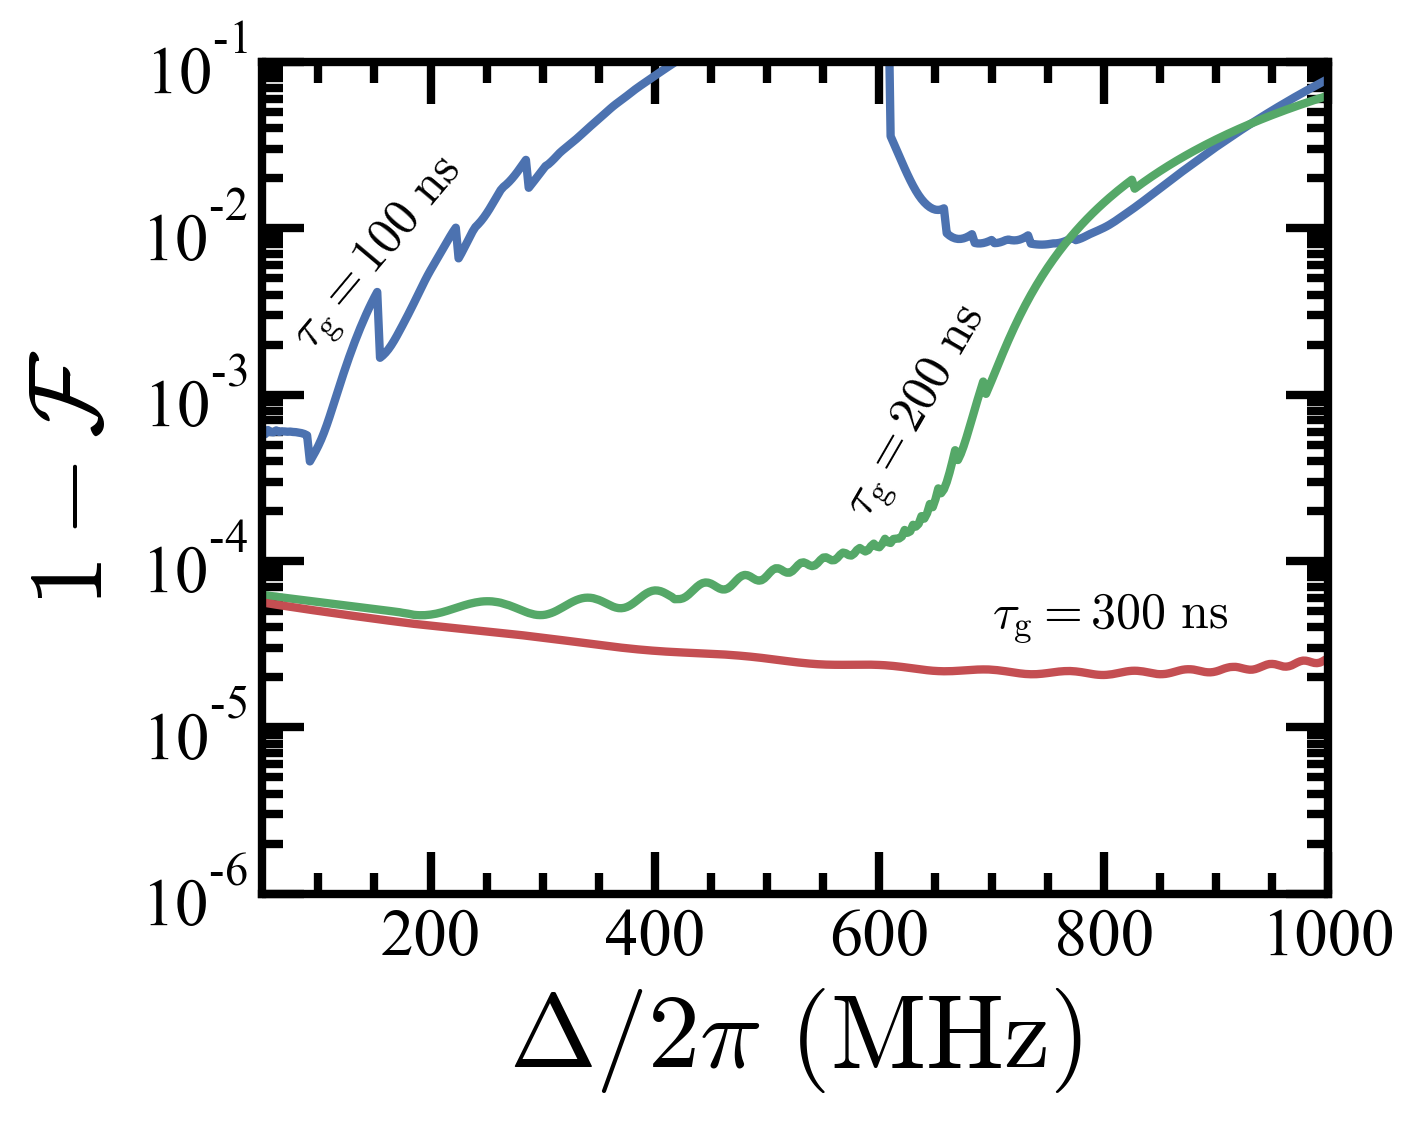

In [2]:
plt.figure(figsize = [5,4])
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# detuning_array = np.linspace(50,250,101)*1e-3
# T_gate_array = np.array([100, 200, 300])
# infidelity_array = np.load(figpath+'/CZ_fidelity_vs_detuning_gateTime_TLS.npy')
# plt.semilogy(detuning_array*1e3,infidelity_array[:,0], label=r'$\tau_g=100~\mathrm{ns}$', linewidth = 2.0)
# plt.semilogy(detuning_array*1e3,infidelity_array[:,1], label=r'$\tau_g=200~\mathrm{ns}$', linewidth = 2.0)
# plt.semilogy(detuning_array*1e3,infidelity_array[:,2], label=r'$\tau_g=300~\mathrm{ns}$', linewidth = 2.0)


# detuning_array = np.linspace(50,250,101)*1e-3
# T_gate_array = np.array([100, 200, 300])
# infidelity_array = np.load(figpath+'/CZ_fidelity_vs_detuning_gateTime1_TLS.npy')
# plt.semilogy(detuning_array*1e3,infidelity_array[:,0], label=r'$\tau_g=100~\mathrm{ns}$', linewidth = 2.0)
# plt.semilogy(detuning_array*1e3,infidelity_array[:,1], label=r'$\tau_g=200~\mathrm{ns}$', linewidth = 2.0)
# plt.semilogy(detuning_array*1e3,infidelity_array[:,2], label=r'$\tau_g=300~\mathrm{ns}$', linewidth = 2.0)

detuning_array = np.linspace(50,1000,381)*1e-3
T_gate_array = np.array([100, 200, 300])
infidelity_array = np.load(figpath+'/CZ_fidelity_vs_detuning_1GHz_gateTime_TLS.npy')
plt.semilogy(detuning_array*1e3,infidelity_array[:,0], label=r'$\tau_g=100~\mathrm{ns}$', linewidth = 2.0)
# plt.semilogy(detuning_array*1e3,infidelity_array[:,1], label=r'$\tau_g=200~\mathrm{ns}$', linewidth = 2.0)
# plt.semilogy(detuning_array*1e3,infidelity_array[:,2], label=r'$\tau_g=300~\mathrm{ns}$', linewidth = 2.0)
plt.text(67,2e-3,r'$\tau_\mathrm{g}=100~\mathrm{ns}$',rotation = 50, fontsize = 12)
plt.text(560,2e-4,r'$\tau_\mathrm{g}=200~\mathrm{ns}$',rotation = 60, fontsize = 12)
plt.text(700,4e-5,r'$\tau_\mathrm{g}=300~\mathrm{ns}$',rotation = 0, fontsize = 12)

detuning_array = np.linspace(50,1000,381)*1e-3
T_gate_array = np.array([100, 200, 300])
infidelity_array = np.load(figpath+'/CZ_fidelity_vs_detuning_1GHz_gateTime_TLS1.npy')
# plt.semilogy(detuning_array*1e3,infidelity_array[:,0], label=r'$\tau_g=100~\mathrm{ns}$', linewidth = 2.0)
plt.semilogy(detuning_array*1e3,infidelity_array[:,1], label=r'$\tau_g=200~\mathrm{ns}$', linewidth = 2.0)
plt.semilogy(detuning_array*1e3,infidelity_array[:,2], label=r'$\tau_g=300~\mathrm{ns}$', linewidth = 2.0)

# plt.axvline(drive_freq-)
# plt.xlim([50,250])
# plt.ylim([3e-5, 1e-1])
plt.xlim([detuning_array[0]*1e3,detuning_array[-1]*1e3])
plt.ylim([1e-6,1e-1])
# plt.legend()
plt.xlabel(r'$\Delta/2\pi~(\mathrm{MHz})$')
plt.ylabel(r'$1-\mathcal{F}$')
plt.tight_layout()
figname = 'CZ_extended.pdf'
plt.savefig(figpath+figname)

# Pauli transfer matrix

In [48]:
w1 = 0.45
w2 = 0.5
J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System
state_00 = eig_states[0]

coupl1 = 41.84249824  #MHz
coupl2= 23.61029908
coupl_const1 = coupl1*1e-3*2*np.pi
coupl_const2 = coupl2*1e-3*2*np.pi
H1 = coupl_const1*XI+coupl_const2*IX

delta_omega_d = 50e-3
drive_freq = eig_energies[2]-eig_energies[0] + delta_omega_d #qubit A

shape ='cos'
#With decoherence
t1 = 1000e3 #unit is ns
t2 = 100000e3 #unit is ns
prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_ops:
    for q2gate in prep_ops:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)     
        
states_in = []
states_out = []

gamma1 = t1**(-1.0)
gamma2 = t2**(-1.0)
c1 = np.sqrt(gamma1)*(tensor(sigmam(),qeye(2)) + tensor(qeye(2),sigmam()))
c2 = np.sqrt(gamma2/2.0) *(tensor(sigmaz(),qeye(2)) + tensor(qeye(2),sigmaz()))
    
#Ideal case
for i, prep in enumerate(prep_rotations):
    psi_in = prep*state_00
    evol_states_veryideal = U_ideal*psi_in
    psi_out = np.array(ket2dm(evol_states_veryideal))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
ptm_ideal = tomography.get_process_matrix(states_in, states_out, physical=True)

#No dephasing
# states_in = []
# states_out = []
# for i, prep in enumerate(prep_rotations):
#     psi_in = prep*state_00
#     evol_states_ideal = gates.evolution_psi_microwave_nonorm_diss(H0, H1, psi0 =psi_in, t_points=t_points, c_ops = [],
#                                             T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
#     psi_out = np.array(ket2dm(single_qu_z*evol_states_ideal[-1]))
#     psi_in = np.array(ket2dm(psi_in))
#     states_in.append(psi_in)
#     states_out.append(psi_out)
# ptm_ideal = tomography.get_process_matrix(states_in, states_out, physical=True)

#Real case
states_in = []
states_out = []
for i, prep in enumerate(prep_rotations):
    psi_in = prep*state_00
    evol_states_real = gates.evolution_psi_microwave_nonorm_diss(H0, H1, psi0 =psi_in, t_points=t_points, c_ops = [c1,c2],
                                            T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
    psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
#     psi_out = np.array(evol_states_real[-1])
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
        
ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)

<ipython-input-48-bd881bd20b22>:21: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]


In [49]:
print (tomography.process_fidelity(ptm_real, ptm_ideal))

0.9999384611290074


In [45]:
ptm_error = ptm_real@np.linalg.inv(ptm_ideal)

NameError: name 'op_label' is not defined

## PTM to chi

<ipython-input-46-9d73738da60b>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_generator = [qeye(2), rx(np.pi/2.0), ry(np.pi/2.0), sigmax()]


(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fa2912225b0>)

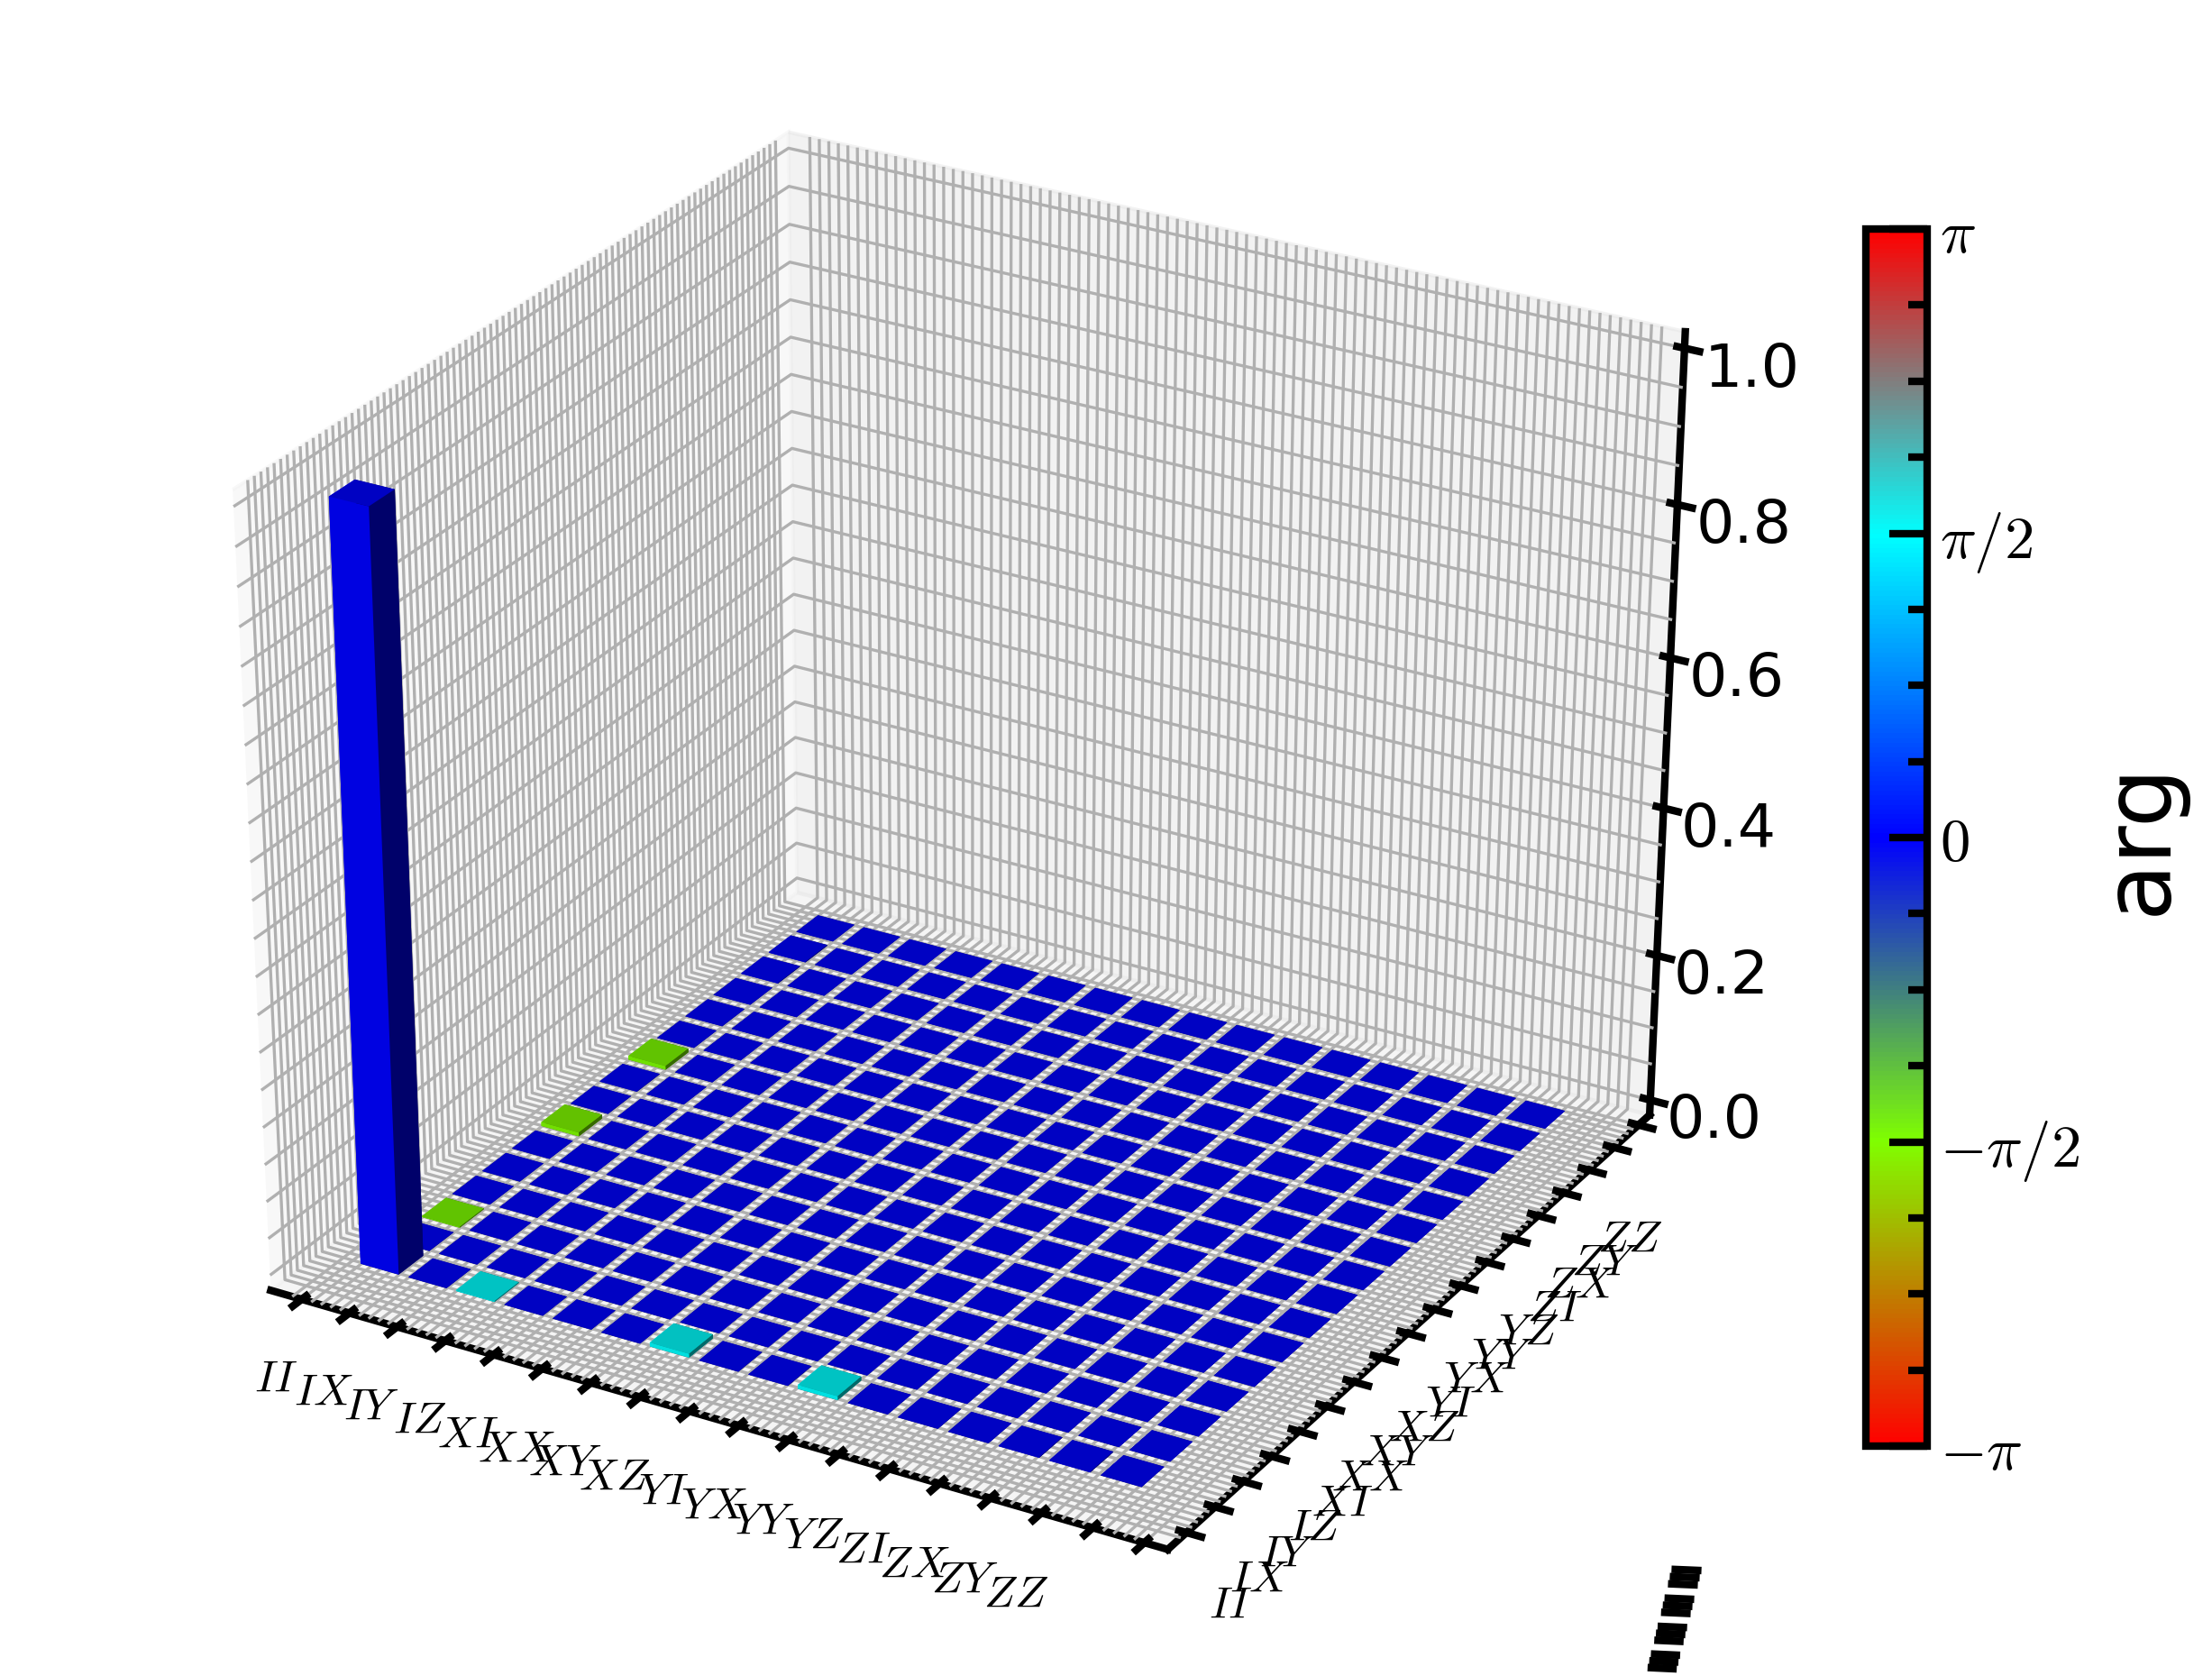

In [46]:
prep_generator = [qeye(2), rx(np.pi/2.0), ry(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_generator:
    for q2gate in prep_generator:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)

meas_generator = [qeye(2), sigmax(), sigmay(), sigmaz()]
meas_rotations = []
for q1gate in meas_generator:
    for q2gate in meas_generator:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
        
p_in = np.zeros((16,16))  
gnd_state = tensor(basis(2,0), basis(2,0))
for i, rot_i in enumerate(prep_rotations):
    for j, rot_j in enumerate(meas_rotations):
        p_in[i,j] = expect(rot_j, rot_i*gnd_state)
        
# Define set of input states
rho_input = []
for i, prep in enumerate(prep_rotations):
    rho = prep*gnd_state
    rho = ket2dm(rho)
    rho_input.append(rho)
    
#Get output states from PTM    
p_out = p_in@ptm_error
# p_out = p_in@ptm_real
rho_output = []
for idx in range (len(rho_input)):
    rho = 0
    for j, meas in enumerate(meas_rotations):
        rho = rho + 0.25*p_out[idx,j]*meas
    rho_output.append(rho)
    
# Quantum process tomography
n = 2
d = 2**n
la = np.zeros(d**4, dtype = complex)
chi = np.zeros(d**4, dtype = complex)
beta = np.zeros((d**4,d**4), dtype = complex)
for j in range(16):
    for k in range(16):
        la[k+16*j] = (rho_output[j]*rho_input[k]).tr()
        for m in range(16):
            for n in range(16):
                 beta[k+16*j, n+16*m] = (meas_rotations[m]*rho_input[j]*meas_rotations[n]*rho_input[k]).tr()

kappa = np.linalg.inv(beta)
chi = kappa.dot(la)
chi = np.reshape(chi, (16,16)).transpose()
# for m in range(4):
#     for n in range(4):
#         for j in range(4):
#             for k in range(4):
#                 chi[n+4*m] = chi[n+4*m]+ kappa[m,n,j,k]*la[j,k]

op_label = [["$I$", "$X$", "$Y$", "$Z$"] for i in range (2)]

qpt_plot_combined(chi, op_label) 

In [47]:
fname = r'/Users/longnguyen/Google Drive/LBL Research/Data/HCF simulation/HCF_CZ_error_chi.npy'
np.save(fname, chi)

In [50]:
data=np.load(fname)
print (data)

[[ 9.99638838e-01+3.13837920e-16j -1.61170800e-06+1.40757761e-04j
   3.72060126e-07-1.16594602e-03j -5.54938727e-05-4.25793927e-05j
  -6.14266820e-06+8.38552911e-05j -3.16802464e-06+8.00710307e-07j
  -1.15148768e-06-5.25975653e-03j  4.79122609e-06-2.08717576e-04j
   7.31395402e-07-3.13489539e-04j  1.45691252e-06-5.26204136e-03j
  -3.24538949e-06+7.10466618e-07j -3.74986098e-06-1.41188891e-04j
  -8.03987293e-05-4.13022896e-05j  6.87280755e-07+7.14389860e-04j
   9.98665120e-07-9.09534132e-04j -4.21813771e-05+7.19051122e-06j]
 [-1.61170800e-06-1.40757761e-04j  3.35561278e-05+2.77297771e-16j
  -1.97720579e-07-3.29969546e-05j -1.86557435e-08-4.04119857e-09j
   7.74776894e-07-2.66322266e-06j -1.55661640e-07-3.95955479e-08j
  -6.84559280e-07-1.54027414e-07j  3.60785232e-08+3.60981531e-08j
  -2.77613052e-06-1.09235066e-06j -7.83868254e-07+1.56609495e-07j
  -1.69731271e-07-4.97064815e-08j  1.13903163e-07+4.48375535e-09j
  -2.27015827e-08+4.40156856e-08j  5.41793316e-06-9.28354228e-06j
  -9.7892

# Three-qubitches
## Definitions

In [ ]:
#Define coupled two-level system Hamiltonian
III = tensor(qeye(2), qeye(2), qeye(2))
IIZ = tensor(qeye(2), qeye(2), sigmaz())
IZI = tensor(qeye(2), sigmaz(), qeye(2))
ZII = tensor(sigmaz(), qeye(2), qeye(2))

IIX = tensor(qeye(2), qeye(2), sigmax())
IXI = tensor(qeye(2), sigmax(), qeye(2))
XII = tensor(sigmax(), qeye(2), qeye(2))

IIY = tensor(qeye(2), qeye(2), sigmay())
IYI = tensor(qeye(2), sigmay(), qeye(2))
YII = tensor(sigmay(), qeye(2), qeye(2))

XXI = tensor(sigmax(), sigmax(), qeye(2))
IXX = tensor(qeye(2), sigmax(), sigmax())

def three_q_hamiltonian(w1, w2, w3, J12, J23):
    return 0.5*w1*ZII + 0.5*w2*IZI + 0.5*w3*IIZ + J12*XXI + J23*IXX #+ 15*III

def r_metric(vec0, vec1):
    return 0.5*abs(vec0 - vec1)


#TESTING
w1 = 5.23
w2 = 5.29
w3 = 5.46
J12 = 2.5e-3
J23 = 2.73e-3
H0 = three_q_hamiltonian(w1, w2, w3, J12, J23)
eig_energies, eig_states = H0.eigenstates() #System
print (eig_energies)
print(eig_energies[1]-eig_energies[0])
print(eig_energies[2]-eig_energies[0])
print(eig_energies[3]-eig_energies[0])

In [ ]:
plt.axvline(x = w1)
plt.axvline(x = w2)
plt.axvline(x = w3)
plt.axvline(x = w1 + 10e-3, linestyle = '--', color = 'C1')
plt.xlabel('Frequency (GHz)')

## Parameters

In [ ]:
#Driving part

#1-2
delta_omega_d = 0.02

drive_freq = eig_energies[1] - eig_energies[0] - delta_omega_d #qubit B
detune_1 = delta_omega_d
# detune_2 = delta_omega_d
# detune_3 = drive_freq - w3
ratio_amp12 = -2*J12/detune_1
# ratio_amp12 = 

coupl_const_A = 2
coupl_const_B = ratio_amp12*coupl_const_A
coupl_const_C = 0

H1 = coupl_const_A*XII + coupl_const_B*IXI + coupl_const_C*IIX

#Gate parameters
T_start = 0
T_gate = 400
shape = 'gaussflattop'
# shape = 'square'
sigma = 0.25
T_rise = 100
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2), qeye(2))
U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
U_nothing = gates.evolution_operator_microwave(-H0,H_dum, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

In [ ]:
state_000 = eig_states[0]
state_100 = eig_states[1]
state_010 = eig_states[2]
state_001 = eig_states[3]
state_110 = eig_states[4]
state_101 = eig_states[5]
state_011 = eig_states[6]
state_111 = eig_states[7]


# sup_state0 = (state_00 + state_10)/np.sqrt(2)
# sup_state1 = (state_00 + state_01)/np.sqrt(2)

trans_prob_000_000 = expect(state_000 * state_000.dag(),U_t*state_000)
trans_prob_000_100 = expect(state_100 * state_100.dag(),U_t*state_000)
trans_prob_000_010 = expect(state_010 * state_010.dag(),U_t*state_000)
trans_prob_000_001 = expect(state_001 * state_001.dag(),U_t*state_000)

# sx0 = expect(XI,U_nothing*U_t*sup_state0)
# sy0 = expect(YI,U_nothing*U_t*sup_state0)
# sz0 = expect(ZI,U_nothing*U_t*sup_state0)
# sx1 = expect(IX,U_nothing*U_t*state_00)
# sy1 = expect(IY,U_nothing*U_t*state_00)
# sz1 = expect(IZ,U_nothing*U_t*state_00)

plt.plot(t_points, trans_prob_000_100, label = '100')
plt.plot(t_points, trans_prob_000_010, label = '010')
plt.plot(t_points, trans_prob_000_001, label = '001')

plt.legend()
plt.title(r'Starting in $|00\rangle$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

# b = Bloch()
# b.add_points([sx0, sy0, sz0], meth='l')
# b.make_sphere()

## Phase extraction for ZZ

In [ ]:
phase_12 = np.zeros_like(t_points)
phase_23 = np.zeros_like(t_points)
phase_2 = np.zeros_like(t_points)
U_rw = U_nothing*U_t
for tind in range(len(t_points)):
    u000 = U_rw[tind].matrix_element(state_000.dag(), state_000)
    u100 = U_rw[tind].matrix_element(state_100.dag(), state_100)
    u010 = U_rw[tind].matrix_element(state_010.dag(), state_010)
    u001 = U_rw[tind].matrix_element(state_001.dag(), state_001)
    u110 = U_rw[tind].matrix_element(state_110.dag(), state_110)
    u101 = U_rw[tind].matrix_element(state_101.dag(), state_101)
    u011 = U_rw[tind].matrix_element(state_011.dag(), state_011)
    u111 = U_rw[tind].matrix_element(state_111.dag(), state_111)
    phase_2[tind] = np.angle(u010 * u110 * u011 * u111/(u000 * u100 * u001 * u101))
    phase_12[tind] = np.angle(u110 * u000 * u111 * u001 / (u100 * u010 * u101 * u011))
    phase_23[tind] = np.angle(u011 * u000 * u111 * u100 / (u010 * u001 * u110 * u101))
    
plt.plot(t_points, np.unwrap(phase_2), label = 'IZI')
plt.plot(t_points, np.unwrap(phase_12), label = 'ZZI')
plt.plot(t_points, np.unwrap(phase_23), label = 'IZZ')
# plt.plot(t_points, np.unwrap(phase_123))
plt.xlabel('(ns)')
plt.ylabel('Radian')

opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_12), xdata = t_points)
print (r'$\zeta_{ZZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_23), xdata = t_points)
print (r'$\zeta_{IZZ}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_2), xdata = t_points)
print (r'$\zeta_{IZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 
plt.legend()

## Applying two drives

In [ ]:
from Fluxonium_hamiltonians import qchard_evolgates_twod as gates_twod
#Static part
#Ravi's paper LO is at 5.425 GHz, detuned by -130MHz, qubit 4 is at 5.25 GHz, qubit 4 is at 5.3
#zeta_ZZ -> 4 MHz, driven with same aplitubes

delta_omega_d = 20e-3
coupl_const_A = 50
coupl_const_B = ratio_amp12*coupl_const_A*0.6
coupl_const_C = 100

drive_freq1 = eig_energies[1]-eig_energies[0] - delta_omega_d #qubit B
drive_freq2 = eig_energies[3]-eig_energies[0] + delta_omega_d
# print (drive_freq)
H1 = coupl_const_A*XII + 0.5*coupl_const_B*IXI + 0*IIX
H2 = 0*XII + coupl_const_B*IXI + coupl_const_C*IIX

#Gate parameters
T_start = 0
T_gate = 400
shape = 'gaussflattop'
sigma = 0.25
T_rise = 100
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2), qeye(2))
U_t = gates_twod.evolution_operator_microwave(H0,H1,H2, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d1=drive_freq1, omega_d2 = drive_freq2)

U_nothing = gates.evolution_operator_microwave(-H0,H_dum, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq2)

In [ ]:
phase_12 = np.zeros_like(t_points)
phase_23 = np.zeros_like(t_points)
phase_123 = np.zeros_like(t_points)
U_rw = U_nothing*U_t
for tind in range(len(t_points)):
    u000 = U_rw[tind].matrix_element(state_000.dag(), state_000)
    u100 = U_rw[tind].matrix_element(state_100.dag(), state_100)
    u010 = U_rw[tind].matrix_element(state_010.dag(), state_010)
    u001 = U_rw[tind].matrix_element(state_001.dag(), state_001)
    u110 = U_rw[tind].matrix_element(state_110.dag(), state_110)
    u101 = U_rw[tind].matrix_element(state_101.dag(), state_101)
    u011 = U_rw[tind].matrix_element(state_011.dag(), state_011)
    u111 = U_rw[tind].matrix_element(state_111.dag(), state_111)
    phase_2[tind] = np.angle(u010 * u110 * u011 * u111/(u000 * u100 * u001 * u101))
    phase_12[tind] = np.angle(u110 * u000 * u111 * u001 / (u100 * u010 * u101 * u011))
    phase_23[tind] = np.angle(u011 * u000 * u111 * u100 / (u010 * u001 * u110 * u101))
    
plt.plot(t_points, np.unwrap(phase_2), label = 'IZI')
plt.plot(t_points, np.unwrap(phase_12), label = 'ZZI')
plt.plot(t_points, np.unwrap(phase_23), label = 'IZZ')
# plt.plot(t_points, np.unwrap(phase_123))
plt.legend()
plt.xlabel('(ns)')
plt.ylabel('Radian')

opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_12), xdata = t_points)
print (r'$\zeta_{ZZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_23), xdata = t_points)
print (r'$\zeta_{IZZ}$', opt[0]*1e3/(2*np.pi) , "MHz") 
opt,cov = curve_fit(linear_func, ydata = np.unwrap(phase_2), xdata = t_points)
print (r'$\zeta_{IZI}$', opt[0]*1e3/(2*np.pi) , "MHz") 

In [ ]:
state_000 = eig_states[0]
state_100 = eig_states[1]
state_010 = eig_states[2]
state_001 = eig_states[3]
state_110 = eig_states[4]
state_101 = eig_states[5]
state_011 = eig_states[6]
state_111 = eig_states[7]
print(eig_energies)

sup_state0 = (state_000 + state_010)/np.sqrt(2)
sup_state1 = (state_001 + state_011)/np.sqrt(2)
sup_state2 = (state_100 + state_110)/np.sqrt(2)
sup_state3 = (state_101 + state_111)/np.sqrt(2)

trans_prob_000_000 = expect(state_000 * state_000.dag(),U_t*state_000)
trans_prob_000_100 = expect(state_100 * state_100.dag(),U_t*state_000)
trans_prob_000_010 = expect(state_010 * state_010.dag(),U_t*state_000)
trans_prob_000_001 = expect(state_001 * state_001.dag(),U_t*state_000)

rotation_00 = expect(IXI,U_nothing*U_t*sup_state0)
rotation_01 = expect(IXI,U_nothing*U_t*sup_state1)
rotation_10 = expect(IXI,U_nothing*U_t*sup_state2)
rotation_11 = expect(IXI,U_nothing*U_t*sup_state3)

print(expect(IXI,sup_state0))
print(expect(IXI,sup_state1))
print(expect(IXI,sup_state2))
print(expect(IXI,sup_state3))

plt.plot(t_points, -rotation_00, label = 'C00')
plt.plot(t_points, rotation_01, label = 'C01')
plt.plot(t_points, rotation_10, label = 'C10')
plt.plot(t_points, -rotation_11, label = 'C11', color = 'orange')
# plt.plot(t_points, rotation_11-rotation_01, label = 'C11')
# plt.plot(t_points, trans_prob_000_000, label = 'C11')

# plt.legend()
plt.title(r'Starting in $|00\rangle$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

In [ ]:
amp = np.linspace(0,1,11)
IZI = np.array([3.765,13])
ZZI_0 = np.array([-0.173,-0.4])
ZZI_1 = np.array
IZZ = np.array([,0.33])